In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# from estimation3_mega import EstimationResult, Estimator


In [2]:

# Define distances and time window configuration
distances = [
    0.5, 
    1.0, 
    1.5
    , 2.0, 2.5, 
    3.0
    # , 4.0, 5.0
    ]
tw_id = 'full_day'

# Time windows consistent with the provided codes
time_windows = [
    # '00:00-01:59:59', '02:00-03:59:59', '04:00-05:59:59',
    # '08:00-09:59:59', '10:00-11:59:59', '12:00-13:59:59',
    # '14:00-15:59:59', '16:00-17:59:59', '18:00-19:59:59',
    # '20:00-21:59:59', '22:00-23:59:59'
    # '08:00-10:00', '10:00-12:00', '12:00-14:00',
    # '14:00-16:00', '16:00-18:00', '18:00-20:00',
    # '20:00-22:00', '22:00-23:59'
    '8-10', '10-12', '12-14',
    '14-16', '16-18', '18-20',
    '20-22', '22-24'
]



# Load time-average results
time_avg_results = {}
for dpg in distances:
    file_path = f'/home/go3/wch_code/jx/real_data/time_average/results/results_dpg_{dpg}_{tw_id}.npz'
    if os.path.exists(file_path):
        data = np.load(file_path, allow_pickle=True)
        time_avg_results[dpg] = data['results']

class EstimationResult:
    def __init__(self, time_window):
        self.time_window = time_window
        self.p_ij_avg = None
        self.o_ij_avg = None
        self.in_relative_errors = None
        self.out_relative_errors = None
        self.in_o_ij_actual = None
        self.out_o_ij_actual = None

time_avg_rela_results = {}
for dpg in distances:
    file_path = f'/home/go3/wch_code/jx/real_data/experiment1_5km/time_average/results/results_dpg_{dpg}_{tw_id}.npz'
    if os.path.exists(file_path):
        data = np.load(file_path, allow_pickle=True)
        time_avg_rela_results[dpg] = data['results']

# Load current estimation results
no_cheat_results = {} # no cheat
for dpg in distances:
    file_path = f'/home/go3/wch_code/jx/real_data/experiment1_5km/shrink_assort_all_time/results2/results_dpg_{dpg}_{tw_id}.npz'
    if os.path.exists(file_path):
        data = np.load(file_path, allow_pickle=True)
        # only load the last 8 time windows
        results = data['results'].item()
        no_cheat_results[dpg] = results

cheat_results = {} # no cheat
for dpg in distances:
    file_path = f'/home/go3/wch_code/jx/real_data/experiment1_5km/shrink_assort_cheat/results3/results_dpg_{dpg}_{tw_id}.npz'
    if os.path.exists(file_path):
        data = np.load(file_path, allow_pickle=True)
        # only load the last 8 time windows
        results = data['results'].item()
        cheat_results[dpg] = results


In [ ]:
avg_

In [ ]:
o_ij_avg[:,33] # 到 33 cell 的 order 量

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

# In sample Order and Customer

## get number of customers in training data

In [97]:
import pandas as pd
import numpy as np
from preprocessing3 import Preprocessor
from estimation3 import Estimator, EstimationResult
import multiprocessing
import os
from datetime import datetime, timedelta
from itertools import product

def time_period_in_minutes(start_time, end_time):
    """
    Calculate the time period in minutes between two time strings.
    
    Args:
        start_time (str): Start time in 'HH:MM' or 'HH:MM:SS' format
        end_time (str): End time in 'HH:MM' or 'HH:MM:SS' format
    
    Returns:
        float: Time period in minutes
    
    Raises:
        ValueError: If time strings are in an invalid format
    """
    try:
        start_dt = datetime.strptime(start_time, '%H:%M:%S')
        end_dt = datetime.strptime(end_time, '%H:%M:%S')
    except ValueError:
        try:
            start_dt = datetime.strptime(start_time, '%H:%M')
            end_dt = datetime.strptime(end_time, '%H:%M')
        except ValueError:
            raise ValueError("Invalid time format. Use 'HH:MM' or 'HH:MM:SS'.")
    
    delta = end_dt - start_dt
    if delta.total_seconds() < 0:
        delta += timedelta(days=1)
    return delta.total_seconds() / 60

In [112]:
data_path = '/home/go3/wch_code/jx/real_data/data/cleaned_data2.csv'
df = pd.read_csv(data_path)
training_dates = ['2022-10-17', '2022-10-18', '2022-10-19']
testing_dates = [
    '2022-10-20', 
    '2022-10-21']
dist_per_grid_list = [
    0.5,
    1.0, 
    1.5, 
    2.0, 2.5, 
    3.0, 
    ]
time_windows_configs = [
        ('08:00:00', '09:59:59'),  
        ('10:00:00', '11:59:59'),
        ('12:00:00', '13:59:59'),
        ('14:00:00', '15:59:59'),  
        ('16:00:00', '17:59:59'),
        ('18:00:00', '19:59:59'),
        ('20:00:00', '21:59:59'),
        ('22:00:00', '23:59:59'),
]

# time_windows = time_windows_configs[0][1]  # Use 'full_day' time windows
timeperiod = time_period_in_minutes(time_windows_configs[0][0], time_windows_configs[0][1])

training_dates = [pd.to_datetime(date).date() for date in training_dates]
testing_dates = [pd.to_datetime(date).date() for date in testing_dates]
all_dates = training_dates + testing_dates
base_df = Preprocessor.preprocess(df, all_dates)

in_sample_customers = {}
out_sample_customers = {}

for dpg in dist_per_grid_list:
    # cust = {}
    base_df, num_total_cells, num_cells_lon, lon_min, lat_min, lon_step, lat_step = Preprocessor.cut_df(base_df, dpg, timeperiod)
    in_cust_tw = {}
    out_cust_tw = {}
    for tw in time_windows_configs:
        print(f'Processing dpg: {dpg}, time window: {tw}')
        win_start = tw[0]
        win_end = tw[1]
        start_time = pd.to_datetime(win_start).time()
        end_time = pd.to_datetime(win_end).time()

        in_cust_date = []
        for train_date in training_dates:
            win_df_train = base_df[(base_df['date'] == train_date) & 
                                    (base_df['time'] >= start_time) & 
                                    (base_df['time'] <= end_time)].copy()
            win_df_train['time_window'] = f"{win_start}-{win_end}"

            cust_actual = np.zeros(num_total_cells)
            for i in range(num_total_cells):
                cust_actual[i] = len(win_df_train[(win_df_train['cust_index'] == i)])
            in_cust_date.append(cust_actual)
        out_cust_date = []
        for test_date in testing_dates:
            win_df_test = base_df[(base_df['date'] == test_date) & 
                                    (base_df['time'] >= start_time) & 
                                    (base_df['time'] <= end_time)].copy()
            win_df_test['time_window'] = f"{win_start}-{win_end}"

            cust_actual = np.zeros(num_total_cells)
            for i in range(num_total_cells):
                cust_actual[i] = len(win_df_test[(win_df_test['cust_index'] == i)])
            out_cust_date.append(cust_actual)

        in_cust_tw[tw] = in_cust_date
        out_cust_tw[tw] = out_cust_date

    in_sample_customers[dpg] = in_cust_tw
    out_sample_customers[dpg] = out_cust_tw



Processing dpg: 0.5, time window: ('08:00:00', '09:59:59')
Processing dpg: 0.5, time window: ('10:00:00', '11:59:59')
Processing dpg: 0.5, time window: ('12:00:00', '13:59:59')
Processing dpg: 0.5, time window: ('14:00:00', '15:59:59')
Processing dpg: 0.5, time window: ('16:00:00', '17:59:59')
Processing dpg: 0.5, time window: ('18:00:00', '19:59:59')
Processing dpg: 0.5, time window: ('20:00:00', '21:59:59')
Processing dpg: 0.5, time window: ('22:00:00', '23:59:59')
Processing dpg: 1.0, time window: ('08:00:00', '09:59:59')
Processing dpg: 1.0, time window: ('10:00:00', '11:59:59')
Processing dpg: 1.0, time window: ('12:00:00', '13:59:59')
Processing dpg: 1.0, time window: ('14:00:00', '15:59:59')
Processing dpg: 1.0, time window: ('16:00:00', '17:59:59')
Processing dpg: 1.0, time window: ('18:00:00', '19:59:59')
Processing dpg: 1.0, time window: ('20:00:00', '21:59:59')
Processing dpg: 1.0, time window: ('22:00:00', '23:59:59')
Processing dpg: 1.5, time window: ('08:00:00', '09:59:59

## In sample customer

In [115]:
in_sample_customers[0.5]

{('08:00:00', '09:59:59'): [array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.])],
 ('10:00:00', '11:59:59'): [array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.])],
 ('12:00:00', '13:59:59'): [array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.])],
 ('14:00:00', '15:59:59'): [array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.])],
 ('16:00:00', '17:59:59'): [array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.])],
 ('18:00:00', '19:59:59'): [array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.])],
 ('20:00:00', '21:59:59'): [array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.]),
  array([0.,

In [132]:
no_cheat_result.omega

array([0.02777778, 0.01499817, 0.00538829, 0.00411603, 0.02785406,
       0.02777778, 0.02785914, 0.00426575, 0.0199816 , 0.02963551,
       0.00576263, 0.02777778, 0.0295061 , 0.00860644, 0.07648361,
       0.08449122, 0.0267169 , 0.01818548, 0.02828176, 0.01145023,
       0.1017034 , 0.07334047, 0.00793292, 0.00112255, 0.02792755,
       0.00583733, 0.03652046, 0.01391985, 0.0279188 , 0.02777778,
       0.02777778, 0.02858913, 0.02923252, 0.02792765, 0.02777778,
       0.02777778])

In [196]:

# Create a DataFrame for comparison
in_sample_cust_df = pd.DataFrame()
distances = [
    0.5, 
    1.0, 
    1.5
    , 2.0, 2.5, 
    3.0
    ]

time_windows = [
    '8-10', 
    '10-12', '12-14',
    '14-16', '16-18', '18-20',
    '20-22', '22-24'
]

for dpg in distances:
    if dpg in time_avg_results and dpg in cheat_results:
        # WMAPE
        ## customer 
        wmapes_cust_time_avg = []
        # wmapes_cust_cheat = []
        wmapes_cust_no_cheat = []

        # Choice Prob Error
        ## customer 
        choprob_cust_time_avg = []
        # choprob_cust_cheat = []
        choprob_cust_no_cheat = []

        # in_relative_errors = None
        # out_relative_errors = None
        # out_sample_assort_ratio = None
        # in_o_ij_actual = None
        # in_o_ij_hat = None
        # in_N_hat = None
        # in_N_actual = None
        # out_o_ij_actual = None
        # out_o_ij_hat = None
        # out_N_hat = None
        # out_N_actual = None

        for tw in time_windows:
            idx = time_windows.index(tw)
            d = list(no_cheat_results[1.0].keys())[idx]
            dd = list(in_sample_customers[1.0].keys())[idx]
            # cheat_results[1.0][d][0].out_sample_wmapes

            time_avg_result = time_avg_results[dpg][idx]
            time_avg_rela_result = time_avg_rela_results[dpg][idx]
            no_cheat_result = no_cheat_results[dpg][d][0]

            in_sample_cust = in_sample_customers[dpg][dd]
            # in_sample_cust_ij = in_sample_customers_ij[dpg][dd]

            # get p estimates
            o_ij_avg = time_avg_rela_result.o_ij_avg[0]
            p_ij_avg = time_avg_rela_result.p_ij_avg[0]
            avg_custom = np.sum(o_ij_avg, axis= 1) 
            num_total_cells = o_ij_avg.shape[1]
            p_hat_no_cheat = no_cheat_result.p_hat

            
            # lambda_hat = no_cheat_result.lambda_hat
            # omega_hat  = no_cheat_result.omega
            # N_cust_hat = lambda_hat * omega_hat * (1- p_hat_no_cheat[:,-1])  # N_cust_hat is the estimated number of customers in each cell

            N_cust_hat = avg_custom * (1- p_hat_no_cheat[:,-1])
            # N_avg_cust_no_cheat = np.array([(avg_custom * p_hat_no_cheat[:, c]).sum() for c in range(num_total_cells)])

            N_cust_1 = in_sample_cust[0]
            N_cust_2 = in_sample_cust[1]
            N_cust_3 = in_sample_cust[2]

            N_cust_1_dirt = no_cheat_result.in_o_ij_actual

            # # combined method, in-sample WMAPE
            wmape_avg1 = np.abs(N_cust_hat - N_cust_1).sum() / N_act_1.sum()
            wmape_avg2 = np.abs(N_cust_hat - N_cust_1).sum() / N_act_2.sum()
            wmape_avg3 = np.abs(N_cust_hat - N_cust_1).sum() / N_act_3.sum()
            wmape_avg = ((wmape_avg1 + wmape_avg2 + wmape_avg3) / 3) * 100
            
            wmapes_cust_no_cheat.append(wmape_avg)

            # time-average method, in-sample WMAPE
            mean_avg = np.sum(o_ij_avg, axis=1) # 焊死
            wmape_avg1 = np.abs(mean_avg - N_cust_1).sum() / N_cust_1.sum()
            wmape_avg2 = np.abs(mean_avg - N_cust_2).sum() / N_cust_2.sum()
            wmape_avg3 = np.abs(mean_avg - N_cust_3).sum() / N_cust_3.sum()
            wmape_avg = ((wmape_avg1 + wmape_avg2 + wmape_avg3) / 3) * 100

            wmapes_cust_time_avg.append(wmape_avg)



            # # time-average, in sample rela error
            # # hybrid, in sample rela error

            # # groud truth
            # cho_prob_cust = no_cheat_result.in_o_ij_actual
            # cho_prob_cust1 = cho_prob_cust[list(cho_prob_cust.keys())[0]]
            # cho_prob_cust2 = cho_prob_cust[list(cho_prob_cust.keys())[1]]
            # cho_prob_cust3 = cho_prob_cust[list(cho_prob_cust.keys())[2]]

            # # estimate & average
            # cho_prob_cust_hat = np.zeros((num_total_cells, num_total_cells))
            # cho_prob_cust_avg = np.zeros((num_total_cells, num_total_cells))
            # for i in range(num_total_cells):
            #     cho_prob_cust_hat[:, i] = N_cust_hat[:, i]/ N_cust_hat[:, i].sum() if N_cust_hat[:, i].sum() > 0 else 0
            #     cho_prob_cust_avg[:, i] = o_ij_avg[:, i] / o_ij_avg[:, i].sum() if o_ij_avg[:, i].sum() > 0 else 0
            
            # # calculate choice probability errors, of estimate
            # rela_error1 = np.abs(cho_prob_cust_hat.flatten - cho_prob_cust1)
            # rela_error2 = np.abs(cho_prob_cust_hat.flatten - cho_prob_cust2)
            # rela_error3 = np.abs(cho_prob_cust_hat.flatten - cho_prob_cust3)
            # rela_error_avg = (rela_error1 + rela_error2 + rela_error3) / 3

            # choprob_cust_no_cheat.append(rela_error_avg)

            # # calculate choice probability errors, of average
            # rela_error1_avg = np.abs(cho_prob_cust_avg.flatten - cho_prob_cust1)
            # rela_error2_avg = np.abs(cho_prob_cust_avg.flatten - cho_prob_cust2)
            # rela_error3_avg = np.abs(cho_prob_cust_avg.flatten - cho_prob_cust3)
            # rela_error_avg_avg = (rela_error1_avg + rela_error2_avg + rela_error3_avg) / 3

            # choprob_cust_time_avg.append(rela_error_avg_avg)
 
        # in sample下面估计出来的grid order和customer

        # in sample choice probability和 ground truth，和average method的比较



        temp_df = pd.DataFrame({
            'Distance': dpg,
            'Time Window': time_windows,

            # 'WMAPE Order Time Avg': wmapes_order_time_avg,
            # 'WMAPE Order No Cheat': wmapes_order_no_cheat,

            # 'Choice Prob Order Time Avg': choprob_order_time_avg,
            # 'Choice Prob Order No Cheat': choprob_order_no_cheat,
            'WMAPE Cust Time Avg': wmapes_cust_time_avg,
            'WMAPE Cust No Cheat': wmapes_cust_no_cheat,

            # 'Choice Prob Cust Time Avg': choprob_cust_time_avg,
            # 'Choice Prob Cust No Cheat': choprob_cust_no_cheat,

        })
        in_sample_cust_df = pd.concat([in_sample_cust_df, temp_df], ignore_index=True)


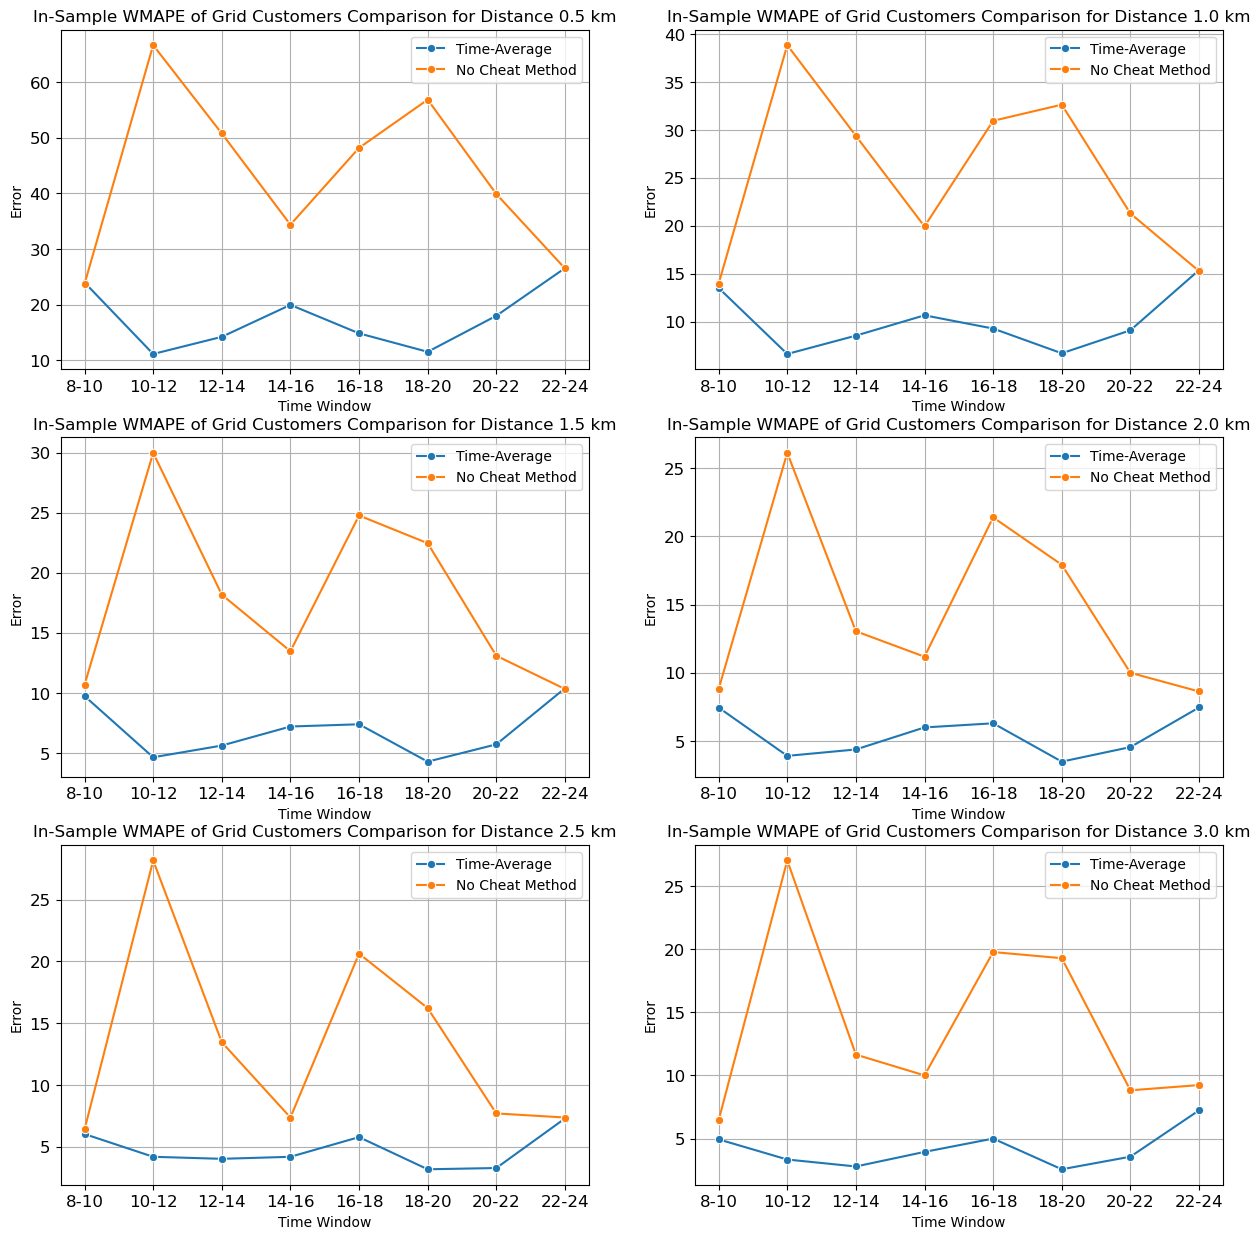

In [198]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()

for i, dpg in enumerate(distances):     
    
    subset = in_sample_cust_df[in_sample_cust_df['Distance'] == dpg]
    # check if wmape is in %
    sns.lineplot(x='Time Window', y='WMAPE Cust Time Avg', data=subset, marker='o', label='Time-Average', ax=axes[i]) 
    sns.lineplot(x='Time Window', y='WMAPE Cust No Cheat', data=subset, marker='o', label='No Cheat Method', ax=axes[i])
    # sns.lineplot(x='Time Window', y='Cheat Method Out Assort Ratio', data=subset, marker='o', label='Cheat Method Assort Ratio', ax=axes[i])
    axes[i].set_title(f'In-Sample WMAPE of Grid Customers Comparison for Distance {dpg} km')
    axes[i].set_ylabel('Error')
    axes[i].set_xlabel('Time Window')
    axes[i].legend()
    axes[i].grid(True)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

## in sample Order

In [ ]:

# Create a DataFrame for comparison
in_sample_df = pd.DataFrame()
distances = [
    0.5, 
    1.0, 
    1.5
    , 2.0, 2.5, 
    3.0
    ]

time_windows = [
    '8-10', 
    '10-12', '12-14',
    '14-16', '16-18', '18-20',
    '20-22', '22-24'
]

for dpg in distances:
    if dpg in time_avg_results and dpg in cheat_results:
        # WMAPE
        ## grid order
        wmapes_order_time_avg = [] # get orders in each grid, then 
        # wmapes_order_cheat = []
        wmapes_order_no_cheat = []
        ## customer 
        wmapes_cust_time_avg = []
        # wmapes_cust_cheat = []
        wmapes_cust_no_cheat = []

        # Choice Prob Error
        ## grid order
        choprob_order_time_avg = []
        # choprob_order_cheat = []
        choprob_order_no_cheat = []
        ## customer 
        choprob_cust_time_avg = []
        # choprob_cust_cheat = []
        choprob_cust_no_cheat = []

        # in_relative_errors = None
        # out_relative_errors = None
        # out_sample_assort_ratio = None
        # in_o_ij_actual = None
        # in_o_ij_hat = None
        # in_N_hat = None
        # in_N_actual = None
        # out_o_ij_actual = None
        # out_o_ij_hat = None
        # out_N_hat = None
        # out_N_actual = None

        for tw in time_windows:
            idx = time_windows.index(tw)
            d = list(cheat_results[1.0].keys())[idx]
            dd = list(in_sample_customers[1.0].keys())[idx]
            # cheat_results[1.0][d][0].out_sample_wmapes

            time_avg_result = time_avg_results[dpg][idx]
            time_avg_rela_result = time_avg_rela_results[dpg][idx]
            no_cheat_result = no_cheat_results[dpg][d][0]
            in_sample_cust = in_sample_customers[dpg][dd]

            # get p estimates
            o_ij_avg = time_avg_rela_result.o_ij_avg[0]
            avg_custom = np.sum(o_ij_avg, axis= 0) 
            num_total_cells = o_ij_avg.shape[1]
            p_hat_no_cheat = no_cheat_result.p_hat

            N_avg_cust_no_cheat = np.array([(avg_custom * p_hat_no_cheat[:, c]).sum() for c in range(num_total_cells)])

            N_act_1 = no_cheat_result.in_N_actual[list(no_cheat_result.in_N_actual.keys())[0]] # orders
            N_act_2 = no_cheat_result.in_N_actual[list(no_cheat_result.in_N_actual.keys())[1]]
            N_act_3 = no_cheat_result.in_N_actual[list(no_cheat_result.in_N_actual.keys())[2]]


            # combined method, in-sample WMAPE
            o_ij_avg = time_avg_rela_result.o_ij_avg[0]
            avg_order = np.sum(o_ij_avg, axis= 1) # sum for each column, means: total customers who made the order in that cell
            num_total_cells = o_ij_avg.shape[1]
            p_hat_no_cheat = no_cheat_result.p_hat
            N_avg_order_no_cheat = np.array([(avg_order * p_hat_no_cheat[:, c]).sum() for c in range(num_total_cells)])

            wmape_avg1 = np.abs(N_avg_order_no_cheat - N_act_1).sum() / N_act_1.sum()
            wmape_avg2 = np.abs(N_avg_order_no_cheat - N_act_2).sum() / N_act_2.sum()
            wmape_avg3 = np.abs(N_avg_order_no_cheat - N_act_3).sum() / N_act_3.sum()
            wmape_avg = ((wmape_avg1 + wmape_avg2 + wmape_avg3) / 3) * 100
            
            wmapes_order_no_cheat.append(wmape_avg)

            # time-average method, in-sample WMAPE
            mean_avg = np.sum(o_ij_avg, axis=0) # sum for each row, mean: total orders will be sent in that cell 
            wmape_avg1 = np.abs(mean_avg - N_act_1).sum() / N_act_1.sum()
            wmape_avg2 = np.abs(mean_avg - N_act_2).sum() / N_act_2.sum()
            wmape_avg3 = np.abs(mean_avg - N_act_3).sum() / N_act_3.sum()
            wmape_avg = ((wmape_avg1 + wmape_avg2 + wmape_avg3) / 3) * 100

            wmapes_order_time_avg.append(wmape_avg)

            # time-average, in sample rela error
            # hybrid, in sample rela error
            time_avg_in_rela_err = np.mean(list(time_avg_rela_result.in_relative_errors[0]) + list(time_avg_rela_result.in_relative_errors[1]) + list(time_avg_rela_result.in_relative_errors[2]))
            no_cheat_in_rela_err = np.mean(list(no_cheat_result.in_relative_errors))

            choprob_order_time_avg.append(time_avg_in_rela_err)
            choprob_order_no_cheat.append(no_cheat_in_rela_err)
            
            # Combined method, in-sample WMAPE for customer
            avg_cust = np.sum(o_ij_avg, axis= 0) 



        temp_df = pd.DataFrame({
            'Distance': dpg,
            'Time Window': time_windows,

            'WMAPE Order Time Avg': wmapes_order_time_avg,
            'WMAPE Order No Cheat': wmapes_order_no_cheat,

            'Choice Prob Order Time Avg': choprob_order_time_avg,
            'Choice Prob Order No Cheat': choprob_order_no_cheat,

            'WMAPE Customer Time Avg': wmapes_cust_time_avg,
            'WMAPE Customer No Cheat': wmapes_cust_no_cheat,

        })
        in_sample_df = pd.concat([in_sample_df, temp_df], ignore_index=True)


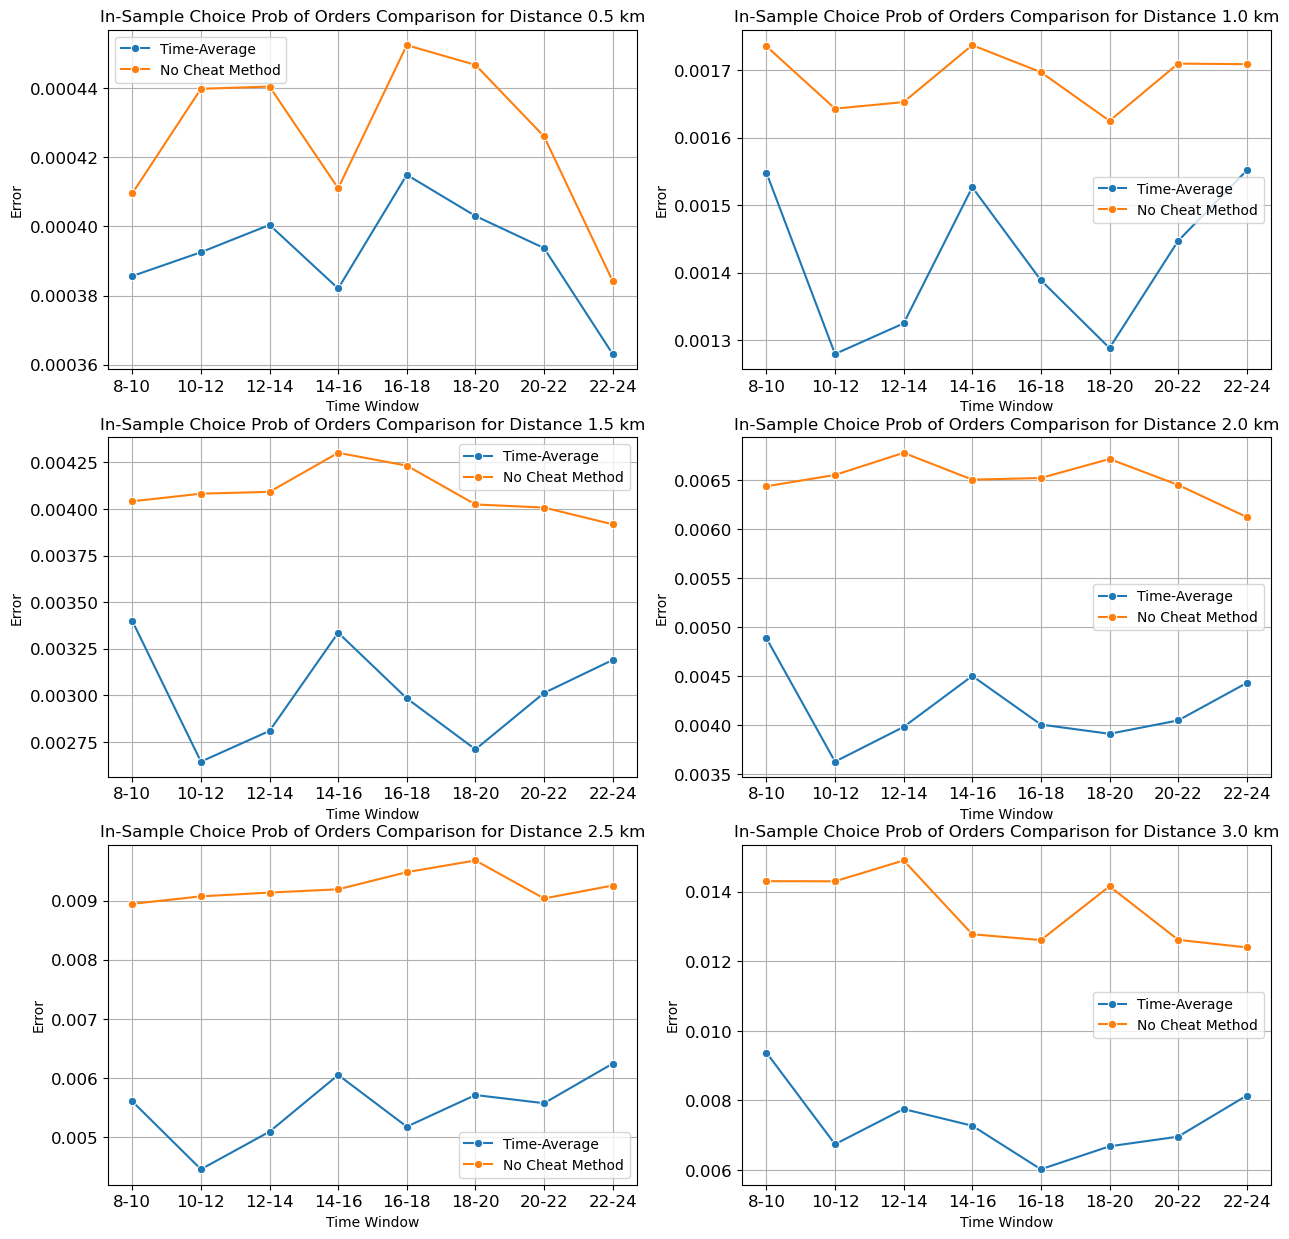

In [87]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()

for i, dpg in enumerate(distances):     
    
    subset = in_sample_df[in_sample_df['Distance'] == dpg]
    # check if wmape is in %
    sns.lineplot(x='Time Window', y='Choice Prob Order Time Avg', data=subset, marker='o', label='Time-Average', ax=axes[i]) 
    sns.lineplot(x='Time Window', y='Choice Prob Order No Cheat', data=subset, marker='o', label='No Cheat Method', ax=axes[i])
    # sns.lineplot(x='Time Window', y='Cheat Method Out Assort Ratio', data=subset, marker='o', label='Cheat Method Assort Ratio', ax=axes[i])
    axes[i].set_title(f'In-Sample Choice Prob of Orders Comparison for Distance {dpg} km')
    axes[i].set_ylabel('Error')
    axes[i].set_xlabel('Time Window')
    axes[i].legend()
    axes[i].grid(True)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

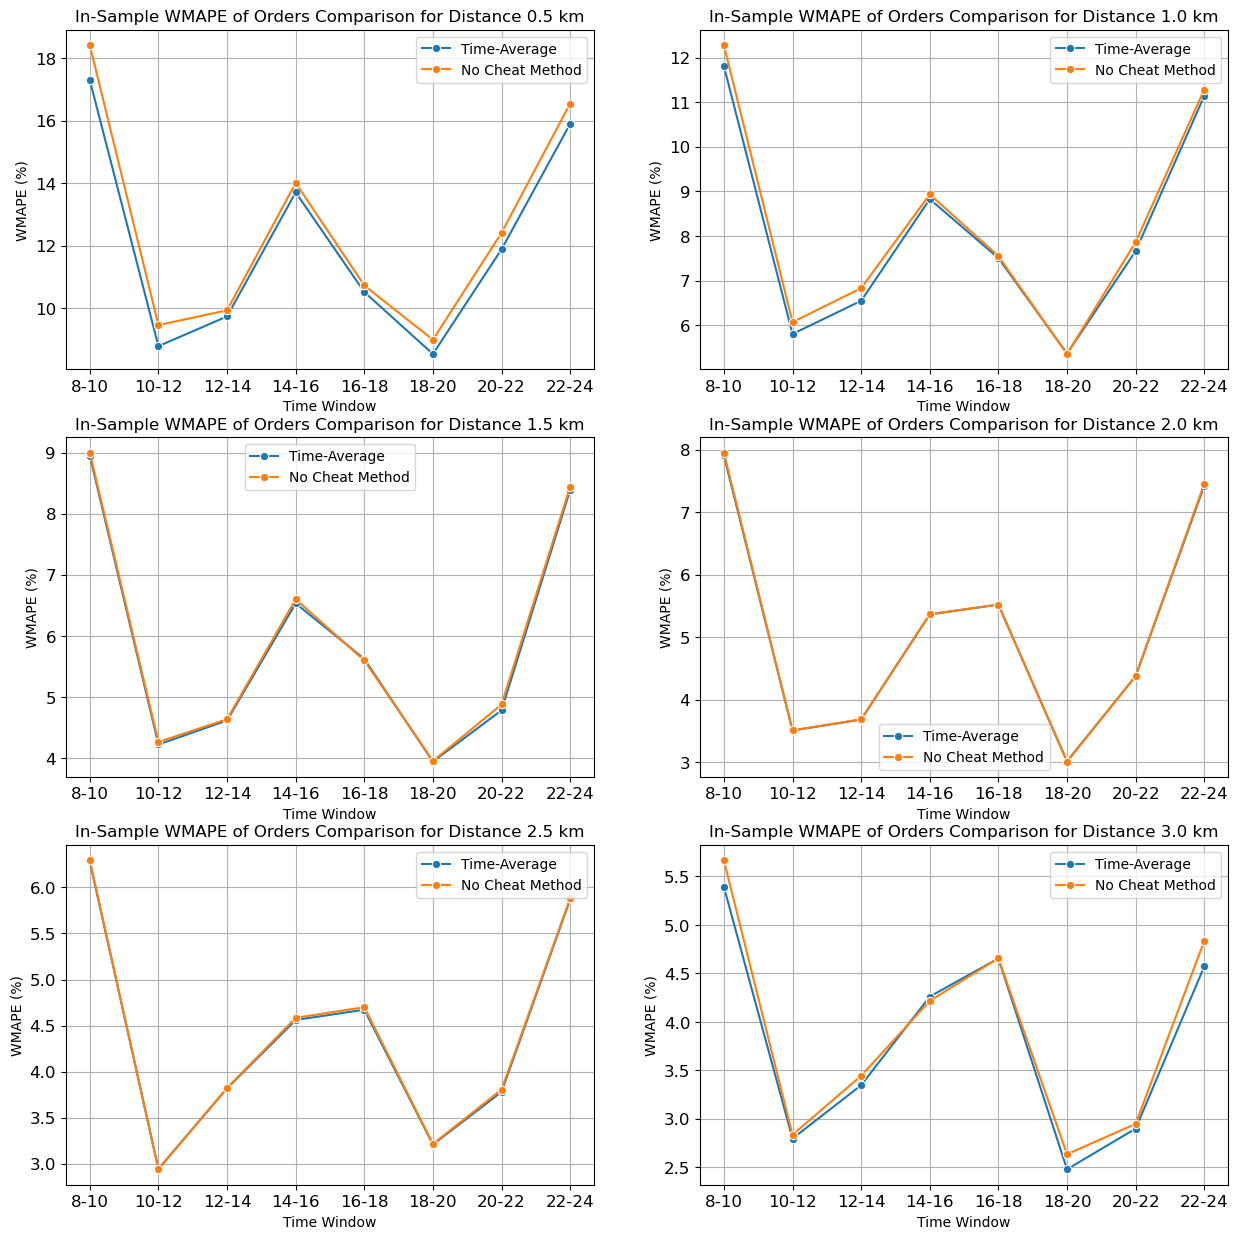

In [89]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()

for i, dpg in enumerate(distances):     
    
    subset = in_sample_df[in_sample_df['Distance'] == dpg]
    # check if wmape is in %
    sns.lineplot(x='Time Window', y='WMAPE Order Time Avg', data=subset, marker='o', label='Time-Average', ax=axes[i]) 
    sns.lineplot(x='Time Window', y='WMAPE Order No Cheat', data=subset, marker='o', label='No Cheat Method', ax=axes[i])
    # sns.lineplot(x='Time Window', y='Cheat Method Out Assort Ratio', data=subset, marker='o', label='Cheat Method Assort Ratio', ax=axes[i])
    axes[i].set_title(f'In-Sample WMAPE of Orders Comparison for Distance {dpg} km')
    axes[i].set_ylabel('WMAPE (%)')
    axes[i].set_xlabel('Time Window')
    axes[i].legend()
    axes[i].grid(True)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

In [ ]:
o_ij_avg = time_avg_rela_result.o_ij_avg[0]

mean_avg = np.mean(o_ij_avg, axis=0)
wmape_avg1 = np.abs(mean_avg - N_act_1).sum() / N_act_1.sum()
wmape_avg2 = np.abs(mean_avg - N_act_2).sum() / N_act_2.sum()
wmape_avg = (wmape_avg1 + wmape_avg2) / 2

In [79]:
o_ij_avg.sum(axis=0) # sum for each column, means: total customers who made the order in that cell

array([  0.        ,   4.66666667,   3.        ,   6.66666667,
         0.        ,   0.        ,   0.        ,   3.        ,
        89.        ,  36.        ,  12.33333333,   0.        ,
         0.        ,   6.66666667, 372.33333333, 593.33333333,
        86.33333333, 105.        ,   0.        ,  13.33333333,
       623.33333333, 343.66666667,   9.66666667,   0.        ,
         0.        ,   8.33333333,  91.66666667,   4.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

In [ ]:
mean_avg # axis = 0

array([  0.        ,   4.66666667,   3.        ,   6.66666667,
         0.        ,   0.        ,   0.        ,   3.        ,
        89.        ,  36.        ,  12.33333333,   0.        ,
         0.        ,   6.66666667, 372.33333333, 593.33333333,
        86.33333333, 105.        ,   0.        ,  13.33333333,
       623.33333333, 343.66666667,   9.66666667,   0.        ,
         0.        ,   8.33333333,  91.66666667,   4.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

In [83]:
avg_custom

array([0.00000000e+00, 4.00000000e+00, 2.40000000e+01, 1.83333333e+01,
       3.33333333e-01, 0.00000000e+00, 3.33333333e-01, 1.90000000e+01,
       8.90000000e+01, 1.32000000e+02, 2.56666667e+01, 0.00000000e+00,
       8.00000000e+00, 3.83333333e+01, 3.40666667e+02, 3.76333333e+02,
       1.19000000e+02, 8.10000000e+01, 2.33333333e+00, 5.10000000e+01,
       4.53000000e+02, 3.26666667e+02, 3.53333333e+01, 5.00000000e+00,
       6.66666667e-01, 2.60000000e+01, 1.62666667e+02, 6.20000000e+01,
       6.66666667e-01, 0.00000000e+00, 0.00000000e+00, 3.66666667e+00,
       6.66666667e+00, 6.66666667e-01, 0.00000000e+00, 0.00000000e+00])

# Out Sample Orders

## N_avg axis = 0

In [ ]:

# Create a DataFrame for comparison
comparison_df = pd.DataFrame()
distances = [
    0.5, 
    1.0, 
    1.5
    , 2.0, 2.5, 
    3.0
    # , 4.0, 5.0
    ]

time_windows = [
    # '00:00-01:59:59', '02:00-03:59:59', '04:00-05:59:59',
    # '08:00-09:59:59', '10:00-11:59:59', '12:00-13:59:59',
    # '14:00-15:59:59', '16:00-17:59:59', '18:00-19:59:59',
    # '20:00-21:59:59', '22:00-23:59:59'
    # '08:00-10:00', '10:00-12:00', '12:00-14:00',
    # '14:00-16:00', '16:00-18:00', '18:00-20:00',
    # '20:00-22:00', '22:00-23:59'
    '8-10', 
    '10-12', '12-14',
    '14-16', '16-18', '18-20',
    '20-22', '22-24'
]

for dpg in distances:
    if dpg in time_avg_results and dpg in cheat_results:
        # wmapes
        time_avg_out_wmapes = []
        cheat_out_wmapes = []
        no_cheat_out_wmapes = []
        
        time_avg_in_wmapes = []
        cheat_in_wmapes = []
        no_cheat_in_wmapes = []
        
        # relative errors
        time_avg_in_rela_errs = []
        cheat_in_rela_errs = []
        no_cheat_in_rela_errs = []

        time_avg_out_rela_errs = []
        cheat_out_rela_errs = []
        no_cheat_out_rela_errs = []
        
        # assort ratios
        time_avg_out_assort_ratios = []
        cheat_out_assort_ratios = []
        no_cheat_out_assort_ratios = []

        # empirical choice prob: 1-D arrary
        time_avg_in_o_ij_actual = []
        cheat_in_o_ij_actual = []
        no_cheat_in_o_ij_actual = []

        time_avg_out_o_ij_actual = []
        cheat_in_out_o_ij_actual = []
        no_cheat_out_o_ij_actual = []

        # expected choice prob: 1-D arrary
        time_avg_in_o_ij_hat = []
        cheat_in_o_ij_hat = []
        no_cheat_in_o_ij_hat = []

        time_avg_out_o_ij_hat = []
        cheat_in_out_o_ij_hat = []
        no_cheat_out_o_ij_hat = []

        # estimated order amount: matrix
        time_avg_in_N_hat = []
        cheat_in_N_hat = []
        no_cheat_in_N_hat = []

        time_avg_out_N_hat = []
        cheat_in_out_N_hat = []
        no_cheat_out_N_hat = []

        # observed order amount: matrix
        time_avg_in_N_actual = []
        cheat_in_in_N_actual = []
        no_cheat_in_N_actual = []

        time_avg_out_N_actual = []
        cheat_in_out_N_actual = []
        no_cheat_out_N_actual = []
        
        # out wmape of combined method
        cheat_our_out_wmapes = []
        no_cheat_our_out_wmapes = []



        # in_relative_errors = None
        # out_relative_errors = None
        # out_sample_assort_ratio = None
        # in_o_ij_actual = None
        # in_o_ij_hat = None
        # in_N_hat = None
        # in_N_actual = None
        # out_o_ij_actual = None
        # out_o_ij_hat = None
        # out_N_hat = None
        # out_N_actual = None

        for tw in time_windows:
            idx = time_windows.index(tw)
            d = list(cheat_results[1.0].keys())[idx]
            # cheat_results[1.0][d][0].out_sample_wmapes

            time_avg_result = time_avg_results[dpg][idx]
            time_avg_rela_result = time_avg_rela_results[dpg][idx]
            cheat_result = cheat_results[dpg][d][0]
            no_cheat_result = no_cheat_results[dpg][d][0]

            # Average out-sample WMAPE over testing dates
            time_avg_out_wmape = np.mean(list(time_avg_result.out_sample_wmapes.values()))
            cheat_out_wmape = np.mean(list(cheat_result.out_sample_wmapes.values()))
            no_cheat_out_wmape = np.mean(list(no_cheat_result.out_sample_wmapes.values()))

            # time_avg_out_wmapes.append(time_avg_out_wmape)
            cheat_out_wmapes.append(cheat_out_wmape)
            no_cheat_out_wmapes.append(no_cheat_out_wmape)

            # Average in-sample WMAPE over training dates
            time_avg_in_wmape = np.mean(list(time_avg_result.in_sample_wmapes.values()))
            cheat_in_wmape = np.mean(list(cheat_result.in_sample_wmapes.values()))
            no_cheat_in_wmape = np.mean(list(no_cheat_result.in_sample_wmapes.values()))

            time_avg_in_wmapes.append(time_avg_in_wmape)
            cheat_in_wmapes.append(cheat_in_wmape)
            no_cheat_in_wmapes.append(no_cheat_in_wmape)

            # # Average out-sample relative errors over testing dates
            time_avg_out_rela_err = np.mean(list(time_avg_rela_result.out_relative_errors[0]) + list(time_avg_rela_result.out_relative_errors[1]))
            cheat_out_rela_err = np.mean(cheat_result.out_relative_errors)
            no_cheat_out_rela_err = np.mean(no_cheat_result.out_relative_errors)

            time_avg_out_rela_errs.append(time_avg_out_rela_err)
            cheat_out_rela_errs.append(cheat_out_rela_err)
            no_cheat_out_rela_errs.append(no_cheat_out_rela_err)

            # # Average in-sample relative errors over training dates
            time_avg_in_rela_err = np.mean(list(time_avg_rela_result.in_relative_errors[0]) + list(time_avg_rela_result.in_relative_errors[1]))
            cheat_in_rela_err = np.mean(list(cheat_result.in_relative_errors))
            no_cheat_in_rela_err = np.mean(list(no_cheat_result.in_relative_errors))

            time_avg_in_rela_errs.append(time_avg_in_rela_err)
            cheat_in_rela_errs.append(cheat_in_rela_err)
            no_cheat_in_rela_errs.append(no_cheat_in_rela_err)

            # # Average out-sample assort ratios over testing dates    
            cheat_out_assort = np.mean(list(cheat_result.out_sample_assort_ratio.values()))
            cheat_out_assort_ratios.append(cheat_out_assort)
            



            # combined method, out-sample WMAPE
            o_ij_avg = time_avg_rela_result.o_ij_avg[0]
            avg_custom = np.sum(o_ij_avg, axis= 1) # sum for each column, means: total customers who made the order in that cell
            num_total_cells = o_ij_avg.shape[1]
            p_hat_no_cheat = no_cheat_result.p_hat
            N_avg_our_no_cheat = np.array([(avg_custom * p_hat_no_cheat[:, c]).sum() for c in range(num_total_cells)])

            N_act_1 = no_cheat_result.out_N_actual[list(no_cheat_result.out_N_actual.keys())[0]] # orders
            N_act_2 = no_cheat_result.out_N_actual[list(no_cheat_result.out_N_actual.keys())[1]]

            # time-average method, out-sample WMAPE
            o_ij_avg = time_avg_rela_result.o_ij_avg[0] # orders in each cell
            mean_avg = np.sum(o_ij_avg, axis=0) # sum for each row, mean: total orders will be sent from that cell 
            wmape_avg1 = np.abs(mean_avg - N_act_1).sum() / N_act_1.sum()
            wmape_avg2 = np.abs(mean_avg - N_act_2).sum() / N_act_2.sum()
            wmape_avg = ((wmape_avg1 + wmape_avg2) / 2) * 100

            time_avg_out_wmapes.append(wmape_avg)

            #no cheat method,
            # mean_avg = N_avg_our_no_cheat.copy()
            wmape_avg1 = np.abs(N_avg_our_no_cheat - N_act_1).sum() / N_act_1.sum()
            wmape_avg2 = np.abs(N_avg_our_no_cheat - N_act_2).sum() / N_act_2.sum()
            wmape_avg = ((wmape_avg1 + wmape_avg2) / 2) * 100

            no_cheat_our_out_wmapes.append(wmape_avg)

            # cheat method 
            p_hat_cheat = cheat_result.p_hat
            N_avg_our_cheat = np.array([(avg_custom * p_hat_cheat[:, c]).sum() for c in range(num_total_cells)])
            # mean_avg = N_avg_our_cheat.copy()
            wmape_avg1 = np.abs(N_avg_our_cheat - N_act_1).sum() / N_act_1.sum()
            wmape_avg2 = np.abs(N_avg_our_cheat - N_act_2).sum() / N_act_2.sum()
            wmape_avg = ((wmape_avg1 + wmape_avg2) / 2) * 100

            cheat_our_out_wmapes.append(wmape_avg)



            # Empirical choice probabilities for in-sample
            # keys = list(time_avg_rela_result.out_o_ij_actual.keys())
            # list(time_avg_rela_result.out_o_ij_actual[keys[0]].flatten()) + list(time_avg_rela_result.out_o_ij_actual[keys[1]].flatten()) 
            
            # time_avg_in_o_ij_actual.append(time_avg_result.in_o_ij_actual)
            # cheat_in_o_ij_actual.append(cheat_result.in_sample_o_ij_actual)
            # no_cheat_in_o_ij_actual.append(no_cheat_result.in_sample_o_ij_actual)

            # # Empirical choice probabilities for out-sample
            # # time_avg_out_o_ij_actual.append(time_avg_result.out_sample_o_ij_actual)
            # cheat_in_out_o_ij_actual.append(cheat_result.out_sample_o_ij_actual)
            # no_cheat_out_o_ij_actual.append(no_cheat_result.out_sample_o_ij_actual)

            # # Expected choice probabilities for in-sample
            # # time_avg_in_o_ij_hat.append(time_avg_result.in_sample_o_ij_hat)
            # cheat_in_o_ij_hat.append(cheat_result.in_sample_o_ij_hat)
            # no_cheat_in_o_ij_hat.append(no_cheat_result.in_sample_o_ij_hat)
            # # Expected choice probabilities for out-sample
            # # time_avg_out_o_ij_hat.append(time_avg_result.out_sample_o_ij_hat)
            # cheat_in_out_o_ij_hat.append(cheat_result.out_sample_o_ij_hat)
            # no_cheat_out_o_ij_hat.append(no_cheat_result.out_sample_o_ij_hat)

            # # Estimated order amount for in-sample
            # # time_avg_in_N_hat.append(time_avg_result.in_sample_N_hat)
            # cheat_in_N_hat.append(cheat_result.in_sample_N_hat)
            # no_cheat_in_N_hat.append(no_cheat_result.in_sample_N_hat)
            # # Estimated order amount for out-sample
            # # time_avg_out_N_hat.append(time_avg_result.out_sample_N_hat)
            # cheat_in_out_N_hat.append(cheat_result.out_sample_N_hat)
            # no_cheat_out_N_hat.append(no_cheat_result.out_sample_N_hat)
            # # Observed order amount for in-sample
            # # time_avg_in_N_actual.append(time_avg_result.in_sample_N_actual)
            # cheat_in_in_N_actual.append(cheat_result.in_sample_N_actual)
            # no_cheat_in_N_actual.append(no_cheat_result.in_sample_N_actual)
            # # Observed order amount for out-sample
            # # time_avg_out_N_actual.append(time_avg_result.out_sample_N_actual)
            # cheat_in_out_N_actual.append(cheat_result.out_sample_N_actual)
            # no_cheat_out_N_actual.append(no_cheat_result.out_sample_N_actual)

        # in sample下面估计出来的grid order和customer

        # in sample choice probability和ground truth，和average method的比较



        temp_df = pd.DataFrame({
            'Distance': dpg,
            'Time Window': time_windows,

            'Time-Average Out WMAPE': time_avg_out_wmapes,
            'Cheat Method Out WMAPE': cheat_out_wmapes,
            'No Cheat Method Out WMAPE': no_cheat_out_wmapes,

            'Time-Average In WMAPE': time_avg_in_wmapes,
            'Cheat Method In WMAPE': cheat_in_wmapes,
            'No Cheat Method In WMAPE': no_cheat_in_wmapes,

            'Time-Average Out Relative Error': time_avg_out_rela_errs,
            'Cheat Method Out Relative Error': cheat_out_rela_errs,
            'No Cheat Method Out Relative Error': no_cheat_out_rela_errs,

            'Time-Average In Relative Error': time_avg_in_rela_errs,
            'Cheat Method In Relative Error': cheat_in_rela_errs,
            'No Cheat Method In Relative Error': no_cheat_in_rela_errs,

            'Cheat Method Out Assort Ratio': cheat_out_assort_ratios,

            'Hybrid: Cheat Method Out WMAPE': cheat_our_out_wmapes,
            'Hybrid: No Cheat Method Out WMAPE': no_cheat_our_out_wmapes

        })
        comparison_df = pd.concat([comparison_df, temp_df], ignore_index=True)


In [56]:
avg_custom

array([0.00000000e+00, 4.00000000e+00, 2.40000000e+01, 1.83333333e+01,
       3.33333333e-01, 0.00000000e+00, 3.33333333e-01, 1.90000000e+01,
       8.90000000e+01, 1.32000000e+02, 2.56666667e+01, 0.00000000e+00,
       8.00000000e+00, 3.83333333e+01, 3.40666667e+02, 3.76333333e+02,
       1.19000000e+02, 8.10000000e+01, 2.33333333e+00, 5.10000000e+01,
       4.53000000e+02, 3.26666667e+02, 3.53333333e+01, 5.00000000e+00,
       6.66666667e-01, 2.60000000e+01, 1.62666667e+02, 6.20000000e+01,
       6.66666667e-01, 0.00000000e+00, 0.00000000e+00, 3.66666667e+00,
       6.66666667e+00, 6.66666667e-01, 0.00000000e+00, 0.00000000e+00])

In [58]:
avg_custom* p_hat_no_cheat[:, 0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [52]:
p_hat_no_cheat.shape

(36, 37)

In [48]:
sum(p_hat_no_cheat[0])

1.0

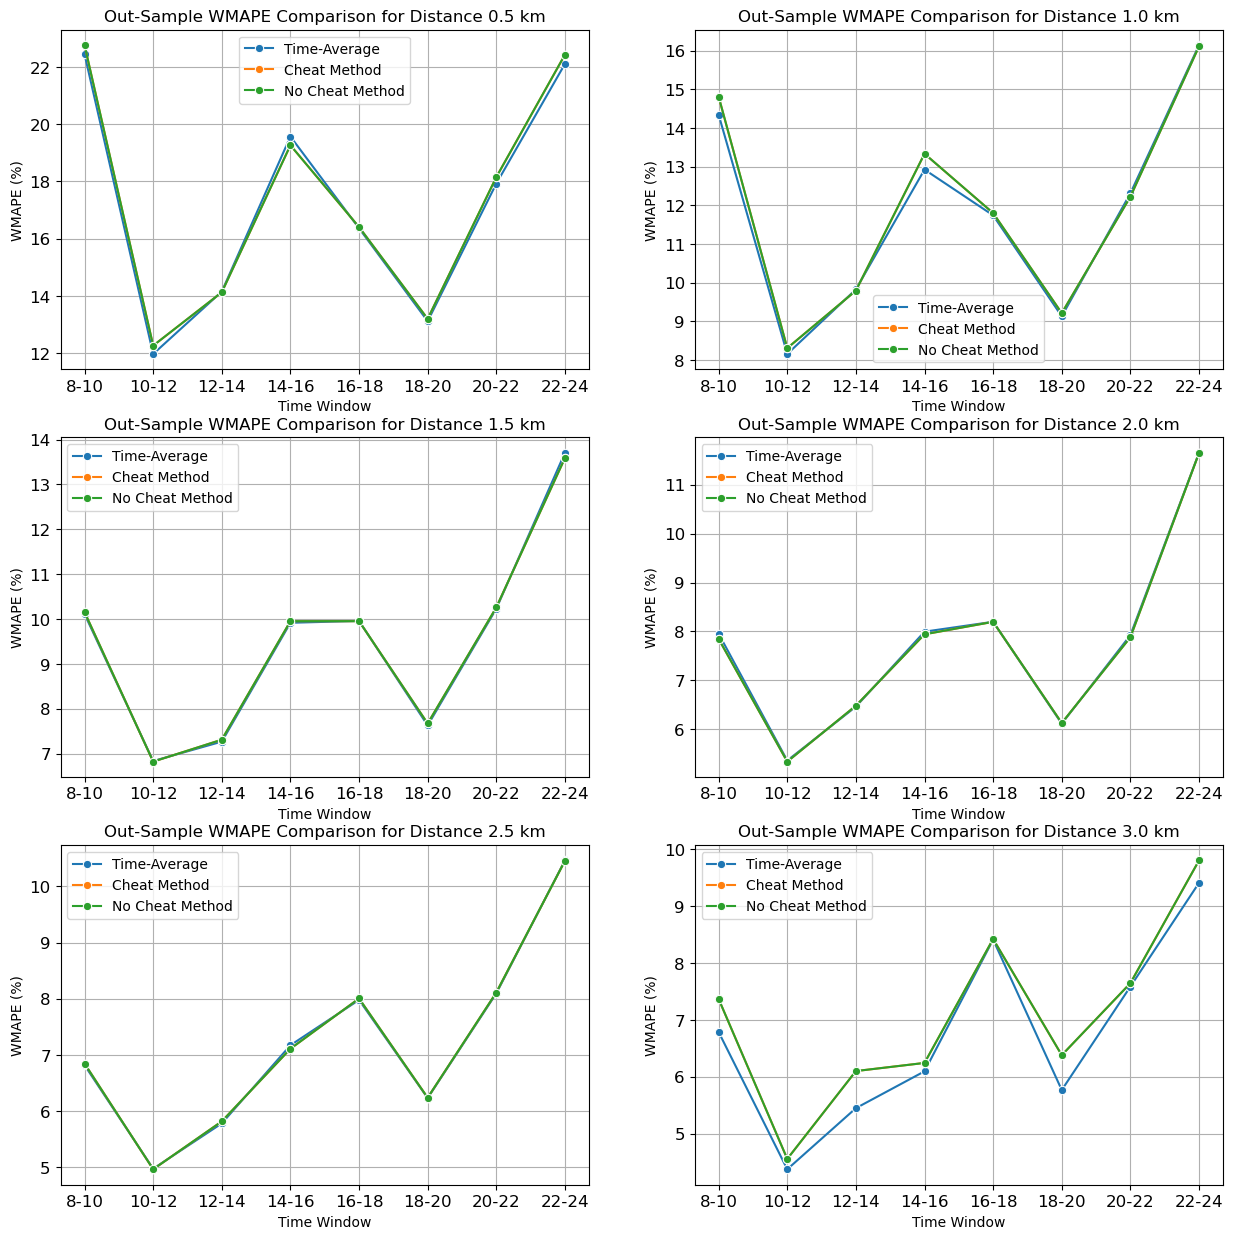

In [64]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()

for i, dpg in enumerate(distances):     
    
    subset = comparison_df[comparison_df['Distance'] == dpg]
    # check if wmape is in %
    sns.lineplot(x='Time Window', y='Time-Average Out WMAPE', data=subset, marker='o', label='Time-Average', ax=axes[i])
    sns.lineplot(x='Time Window', y='Hybrid: Cheat Method Out WMAPE', data=subset, marker='o', label='Cheat Method', ax=axes[i])    
    sns.lineplot(x='Time Window', y='Hybrid: No Cheat Method Out WMAPE', data=subset, marker='o', label='No Cheat Method', ax=axes[i])
    # sns.lineplot(x='Time Window', y='Cheat Method Out Assort Ratio', data=subset, marker='o', label='Cheat Method Assort Ratio', ax=axes[i])
    axes[i].set_title(f'Out-Sample WMAPE Comparison for Distance {dpg} km')
    axes[i].set_ylabel('WMAPE (%)')
    axes[i].set_xlabel('Time Window')
    axes[i].legend()
    axes[i].grid(True)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

In [29]:

col = ['Time-Average Out WMAPE', 'Cheat Method Combined Out WMAPE', 'No Cheat Method Combined Out WMAPE']
comparison_df[col]
# for each row, print the smallest value in the row, and print the column name
# print(comparison_df[col].idxmin(axis=1))

Time-Average Out WMAPE  Cheat Method Combined Out WMAPE  \
0                22.446497                        22.764036   
1                11.972432                        12.264268   
2                14.153568                        14.129571   
3                19.572049                        19.266296   
4                16.365426                        16.408147   
5                13.118249                        13.199608   
6                17.924735                        18.152094   
7                22.107752                        22.430146   
8                14.344589                        14.811577   
9                 8.155928                         8.307139   
10                9.825981                         9.794234   
11               12.925345                        13.334547   
12               11.742182                        11.800624   
13                9.131569                         9.211531   
14               12.310775                        12.224344   
15               16.143266                        16.111045   
16               10.110825                        10.154000   
17                6.836360                         6.822654   
18                7.268372                         7.311606   
19                9.916820                         9.952044   
20                9.957680                         9.952896   
21                7.629394                         7.672409   
22               10.229742                        10.259013   
23               13.704101                        13.586257   
24                7.953650                         7.847978   
25                5.360167                         5.338362   
26                6.463041                         6.482087   
27                7.996490                         7.942656   
28                8.198478                         8.197477   
29                6.114674                         6.128191   
30                7.925170                         7.882075   
31               11.654501                        11.648836   
32                6.818265                         6.847158   
33                4.972154                         4.962959   
34                5.780540                         5.816411   
35                7.171785                         7.109873   
36                7.979898                         8.005353   
37                6.231548                         6.237793   
38                8.096228                         8.111254   
39               10.463808                        10.456048   
40                6.788446                         7.369787   
41                4.375346                         4.557301   
42                5.449986                         6.102474   
43                6.097811                         6.245418   
44                8.413884                         8.424448   
45                5.769088                         6.381894   
46                7.587836                         7.647886   
47                9.411733                         9.805740   

    No Cheat Method Combined Out WMAPE  
0                            22.764036  
1                            12.264268  
2                            14.129571  
3                            19.266296  
4                            16.408147  
5                            13.199608  
6                            18.152094  
7                            22.430146  
8                            14.811577  
9                             8.307139  
10                            9.794234  
11                           13.334547  
12                           11.800624  
13                            9.211531  
14                           12.224344  
15                           16.111045  
16                           10.154000  
17                            6.822654  
18                            7.311606  
19                            9.952044  
20                            9.952896  
21            

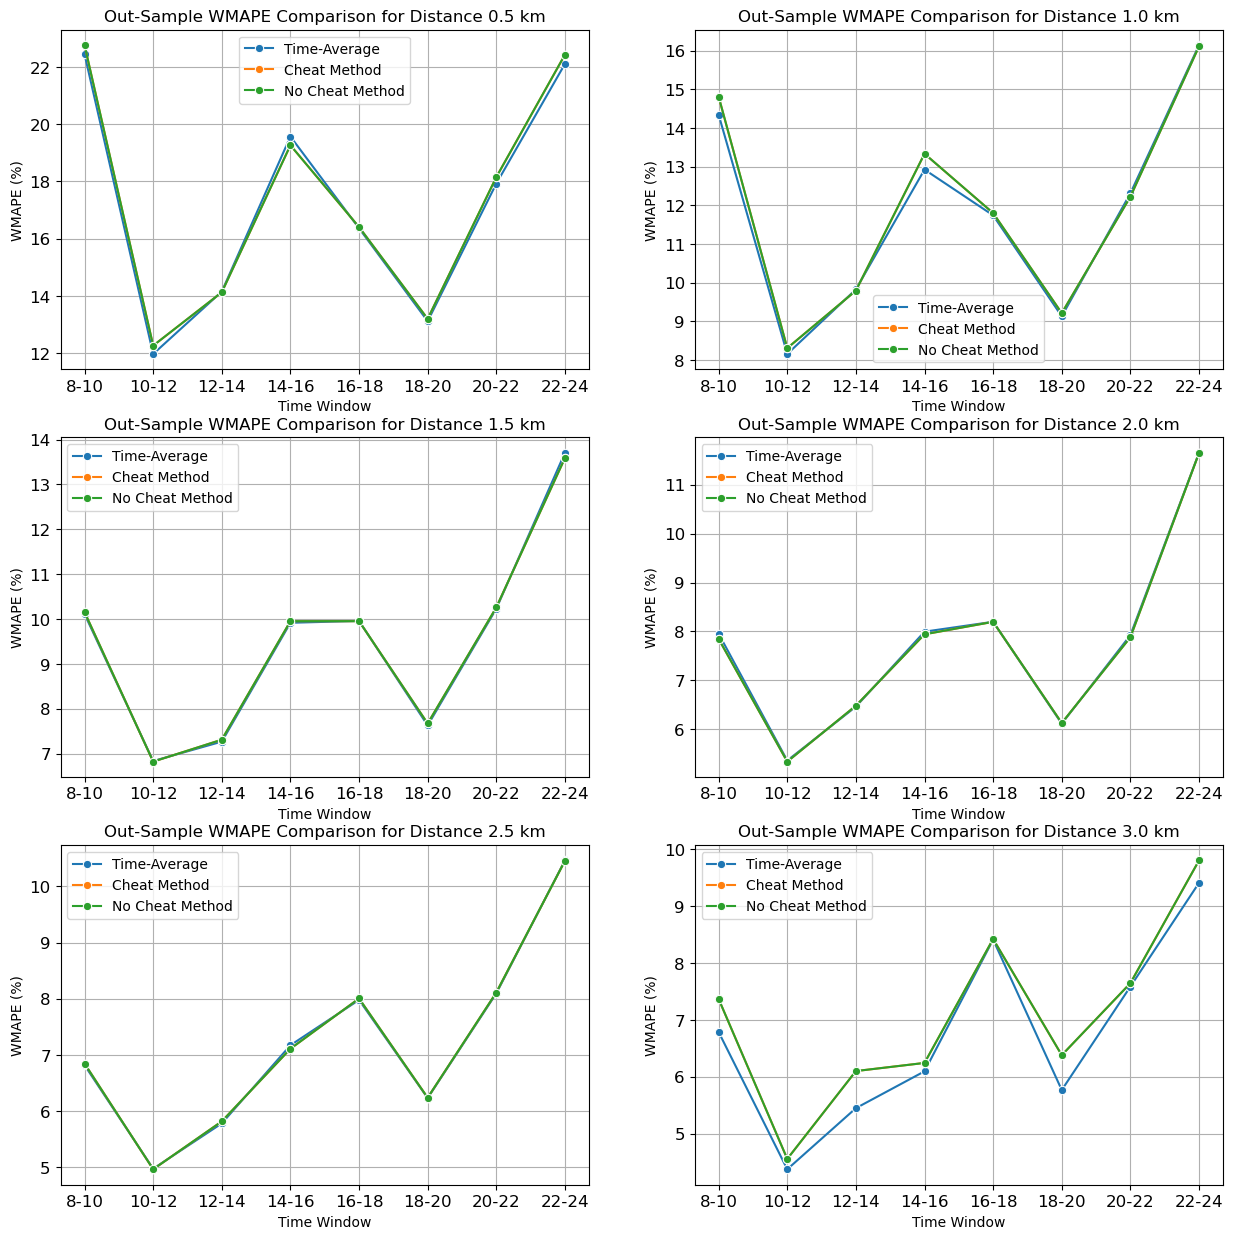

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()

for i, dpg in enumerate(distances):     
    
    subset = comparison_df[comparison_df['Distance'] == dpg]
    # check if wmape is in %
    sns.lineplot(x='Time Window', y='Time-Average Out WMAPE', data=subset, marker='o', label='Time-Average', ax=axes[i])
    sns.lineplot(x='Time Window', y='Cheat Method Combined Out WMAPE', data=subset, marker='o', label='Cheat Method', ax=axes[i])    
    sns.lineplot(x='Time Window', y='No Cheat Method Combined Out WMAPE', data=subset, marker='o', label='No Cheat Method', ax=axes[i])
    # sns.lineplot(x='Time Window', y='Cheat Method Out Assort Ratio', data=subset, marker='o', label='Cheat Method Assort Ratio', ax=axes[i])
    axes[i].set_title(f'Out-Sample WMAPE Comparison for Distance {dpg} km')
    axes[i].set_ylabel('WMAPE (%)')
    axes[i].set_xlabel('Time Window')
    axes[i].legend()
    axes[i].grid(True)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

## axis = 1

In [200]:

# Create a DataFrame for comparison
comparison_df = pd.DataFrame()
distances = [
    0.5, 
    1.0, 
    1.5
    , 2.0, 2.5, 
    3.0
    # , 4.0, 5.0
    ]

time_windows = [
    # '00:00-01:59:59', '02:00-03:59:59', '04:00-05:59:59',
    # '08:00-09:59:59', '10:00-11:59:59', '12:00-13:59:59',
    # '14:00-15:59:59', '16:00-17:59:59', '18:00-19:59:59',
    # '20:00-21:59:59', '22:00-23:59:59'
    # '08:00-10:00', '10:00-12:00', '12:00-14:00',
    # '14:00-16:00', '16:00-18:00', '18:00-20:00',
    # '20:00-22:00', '22:00-23:59'
    '8-10', 
    '10-12', '12-14',
    '14-16', '16-18', '18-20',
    '20-22', '22-24'
]

for dpg in distances:
    if dpg in time_avg_results and dpg in cheat_results:
        # wmapes
        time_avg_out_wmapes = []
        cheat_out_wmapes = []
        no_cheat_out_wmapes = []
        
        time_avg_in_wmapes = []
        cheat_in_wmapes = []
        no_cheat_in_wmapes = []
        
        # relative errors
        time_avg_in_rela_errs = []
        cheat_in_rela_errs = []
        no_cheat_in_rela_errs = []

        time_avg_out_rela_errs = []
        cheat_out_rela_errs = []
        no_cheat_out_rela_errs = []
        
        # assort ratios
        time_avg_out_assort_ratios = []
        cheat_out_assort_ratios = []
        no_cheat_out_assort_ratios = []

        # empirical choice prob: 1-D arrary
        time_avg_in_o_ij_actual = []
        cheat_in_o_ij_actual = []
        no_cheat_in_o_ij_actual = []

        time_avg_out_o_ij_actual = []
        cheat_in_out_o_ij_actual = []
        no_cheat_out_o_ij_actual = []

        # expected choice prob: 1-D arrary
        time_avg_in_o_ij_hat = []
        cheat_in_o_ij_hat = []
        no_cheat_in_o_ij_hat = []

        time_avg_out_o_ij_hat = []
        cheat_in_out_o_ij_hat = []
        no_cheat_out_o_ij_hat = []

        # estimated order amount: matrix
        time_avg_in_N_hat = []
        cheat_in_N_hat = []
        no_cheat_in_N_hat = []

        time_avg_out_N_hat = []
        cheat_in_out_N_hat = []
        no_cheat_out_N_hat = []

        # observed order amount: matrix
        time_avg_in_N_actual = []
        cheat_in_in_N_actual = []
        no_cheat_in_N_actual = []

        time_avg_out_N_actual = []
        cheat_in_out_N_actual = []
        no_cheat_out_N_actual = []
        
        # out wmape of combined method
        cheat_our_out_wmapes = []
        no_cheat_our_out_wmapes = []

        # in_relative_errors = None
        # out_relative_errors = None
        # out_sample_assort_ratio = None
        # in_o_ij_actual = None
        # in_o_ij_hat = None
        # in_N_hat = None
        # in_N_actual = None
        # out_o_ij_actual = None
        # out_o_ij_hat = None
        # out_N_hat = None
        # out_N_actual = None

        for tw in time_windows:
            idx = time_windows.index(tw)
            d = list(cheat_results[1.0].keys())[idx]
            # cheat_results[1.0][d][0].out_sample_wmapes

            time_avg_result = time_avg_results[dpg][idx]
            time_avg_rela_result = time_avg_rela_results[dpg][idx]
            cheat_result = cheat_results[dpg][d][0]
            no_cheat_result = no_cheat_results[dpg][d][0]

            # Average out-sample WMAPE over testing dates
            time_avg_out_wmape = np.mean(list(time_avg_result.out_sample_wmapes.values()))
            cheat_out_wmape = np.mean(list(cheat_result.out_sample_wmapes.values()))
            no_cheat_out_wmape = np.mean(list(no_cheat_result.out_sample_wmapes.values()))

            time_avg_out_wmapes.append(time_avg_out_wmape)
            cheat_out_wmapes.append(cheat_out_wmape)
            no_cheat_out_wmapes.append(no_cheat_out_wmape)

            # Average in-sample WMAPE over training dates
            time_avg_in_wmape = np.mean(list(time_avg_result.in_sample_wmapes.values()))
            cheat_in_wmape = np.mean(list(cheat_result.in_sample_wmapes.values()))
            no_cheat_in_wmape = np.mean(list(no_cheat_result.in_sample_wmapes.values()))

            time_avg_in_wmapes.append(time_avg_in_wmape)
            cheat_in_wmapes.append(cheat_in_wmape)
            no_cheat_in_wmapes.append(no_cheat_in_wmape)

            # # Average out-sample relative errors over testing dates
            time_avg_out_rela_err = np.mean(list(time_avg_rela_result.out_relative_errors[0]) + list(time_avg_rela_result.out_relative_errors[1]))
            cheat_out_rela_err = np.mean(cheat_result.out_relative_errors)
            no_cheat_out_rela_err = np.mean(no_cheat_result.out_relative_errors)

            time_avg_out_rela_errs.append(time_avg_out_rela_err)
            cheat_out_rela_errs.append(cheat_out_rela_err)
            no_cheat_out_rela_errs.append(no_cheat_out_rela_err)

            # # Average in-sample relative errors over training dates
            time_avg_in_rela_err = np.mean(list(time_avg_rela_result.in_relative_errors[0]) + list(time_avg_rela_result.in_relative_errors[1]))
            cheat_in_rela_err = np.mean(list(cheat_result.in_relative_errors))
            no_cheat_in_rela_err = np.mean(list(no_cheat_result.in_relative_errors))

            time_avg_in_rela_errs.append(time_avg_in_rela_err)
            cheat_in_rela_errs.append(cheat_in_rela_err)
            no_cheat_in_rela_errs.append(no_cheat_in_rela_err)

            # # Average out-sample assort ratios over testing dates    
            cheat_out_assort = np.mean(list(cheat_result.out_sample_assort_ratio.values()))
            cheat_out_assort_ratios.append(cheat_out_assort)
            
            # combined method, out-sample WMAPE
            o_ij_avg = time_avg_rela_result.o_ij_avg[0]
            avg_custom = np.sum(o_ij_avg, axis=1)
            num_total_cells = o_ij_avg.shape[1]
            p_hat_no_cheat = no_cheat_result.p_hat
            N_avg_our_no_cheat = np.array([(avg_custom * p_hat_no_cheat[:, c]).sum() for c in range(num_total_cells)])

            N_act_1 = no_cheat_result.out_N_hat[list(no_cheat_result.out_N_hat.keys())[0]]
            N_act_2 = no_cheat_result.out_N_hat[list(no_cheat_result.out_N_hat.keys())[1]]
            wmape_no_cheat_1 = np.abs(N_avg_our_no_cheat - N_act_1).sum() / N_act_1.sum()* 100
            wmape_no_cheat_2 = np.abs(N_avg_our_no_cheat - N_act_2).sum() / N_act_2.sum()* 100
            wmape_no_cheat_mean = (wmape_no_cheat_1 + wmape_no_cheat_2) / 2

            p_hat_cheat = cheat_result.p_hat
            N_avg_our_cheat = np.array([(avg_custom * p_hat_cheat[:, c]).sum() for c in range(num_total_cells)])
            # N_act_1 = cheat_result.out_N_hat[list(cheat_result.out_N_hat.keys())[0]]
            # N_act_2 = cheat_result.out_N_hat[list(cheat_result.out_N_hat.keys())[1]]
            wmape_cheat_1 = np.abs(N_avg_our_cheat - N_act_1).sum() / N_act_1.sum() * 100
            wmape_cheat_2 = np.abs(N_avg_our_cheat - N_act_2).sum() / N_act_2.sum() * 100
            wmape_cheat_mean = (wmape_cheat_1 + wmape_cheat_2) / 2

            cheat_our_out_wmapes.append(wmape_cheat_mean)
            no_cheat_our_out_wmapes.append(wmape_no_cheat_mean)


            # Empirical choice probabilities for in-sample
            # keys = list(time_avg_rela_result.out_o_ij_actual.keys())
            # list(time_avg_rela_result.out_o_ij_actual[keys[0]].flatten()) + list(time_avg_rela_result.out_o_ij_actual[keys[1]].flatten()) 
            
            # time_avg_in_o_ij_actual.append(time_avg_result.in_o_ij_actual)
            # cheat_in_o_ij_actual.append(cheat_result.in_sample_o_ij_actual)
            # no_cheat_in_o_ij_actual.append(no_cheat_result.in_sample_o_ij_actual)

            # # Empirical choice probabilities for out-sample
            # # time_avg_out_o_ij_actual.append(time_avg_result.out_sample_o_ij_actual)
            # cheat_in_out_o_ij_actual.append(cheat_result.out_sample_o_ij_actual)
            # no_cheat_out_o_ij_actual.append(no_cheat_result.out_sample_o_ij_actual)

            # # Expected choice probabilities for in-sample
            # # time_avg_in_o_ij_hat.append(time_avg_result.in_sample_o_ij_hat)
            # cheat_in_o_ij_hat.append(cheat_result.in_sample_o_ij_hat)
            # no_cheat_in_o_ij_hat.append(no_cheat_result.in_sample_o_ij_hat)
            # # Expected choice probabilities for out-sample
            # # time_avg_out_o_ij_hat.append(time_avg_result.out_sample_o_ij_hat)
            # cheat_in_out_o_ij_hat.append(cheat_result.out_sample_o_ij_hat)
            # no_cheat_out_o_ij_hat.append(no_cheat_result.out_sample_o_ij_hat)

            # # Estimated order amount for in-sample
            # # time_avg_in_N_hat.append(time_avg_result.in_sample_N_hat)
            # cheat_in_N_hat.append(cheat_result.in_sample_N_hat)
            # no_cheat_in_N_hat.append(no_cheat_result.in_sample_N_hat)
            # # Estimated order amount for out-sample
            # # time_avg_out_N_hat.append(time_avg_result.out_sample_N_hat)
            # cheat_in_out_N_hat.append(cheat_result.out_sample_N_hat)
            # no_cheat_out_N_hat.append(no_cheat_result.out_sample_N_hat)
            # # Observed order amount for in-sample
            # # time_avg_in_N_actual.append(time_avg_result.in_sample_N_actual)
            # cheat_in_in_N_actual.append(cheat_result.in_sample_N_actual)
            # no_cheat_in_N_actual.append(no_cheat_result.in_sample_N_actual)
            # # Observed order amount for out-sample
            # # time_avg_out_N_actual.append(time_avg_result.out_sample_N_actual)
            # cheat_in_out_N_actual.append(cheat_result.out_sample_N_actual)
            # no_cheat_out_N_actual.append(no_cheat_result.out_sample_N_actual)

        temp_df = pd.DataFrame({
            'Distance': dpg,
            'Time Window': time_windows,
            'Time-Average Out WMAPE': time_avg_out_wmapes,
            'Cheat Method Out WMAPE': cheat_out_wmapes,
            'No Cheat Method Out WMAPE': no_cheat_out_wmapes,
            'Time-Average In WMAPE': time_avg_in_wmapes,
            'Cheat Method In WMAPE': cheat_in_wmapes,
            'No Cheat Method In WMAPE': no_cheat_in_wmapes,
            'Time-Average Out Relative Error': time_avg_out_rela_errs,
            'Cheat Method Out Relative Error': cheat_out_rela_errs,
            'No Cheat Method Out Relative Error': no_cheat_out_rela_errs,
            'Time-Average In Relative Error': time_avg_in_rela_errs,
            'Cheat Method In Relative Error': cheat_in_rela_errs,
            'No Cheat Method In Relative Error': no_cheat_in_rela_errs,
            'Cheat Method Out Assort Ratio': cheat_out_assort_ratios,
            'Cheat Method Combined Out WMAPE': cheat_our_out_wmapes,
            'No Cheat Method Combined Out WMAPE': no_cheat_our_out_wmapes

            # ,
            # 'Time-Average In WMAPE': time_avg_wmapes,
            # 'Cheat Method In WMAPE': cheat_wmapes,
            # 'No Cheat Method In WMAPE': no_cheat_wmapes
        })
        comparison_df = pd.concat([comparison_df, temp_df], ignore_index=True)


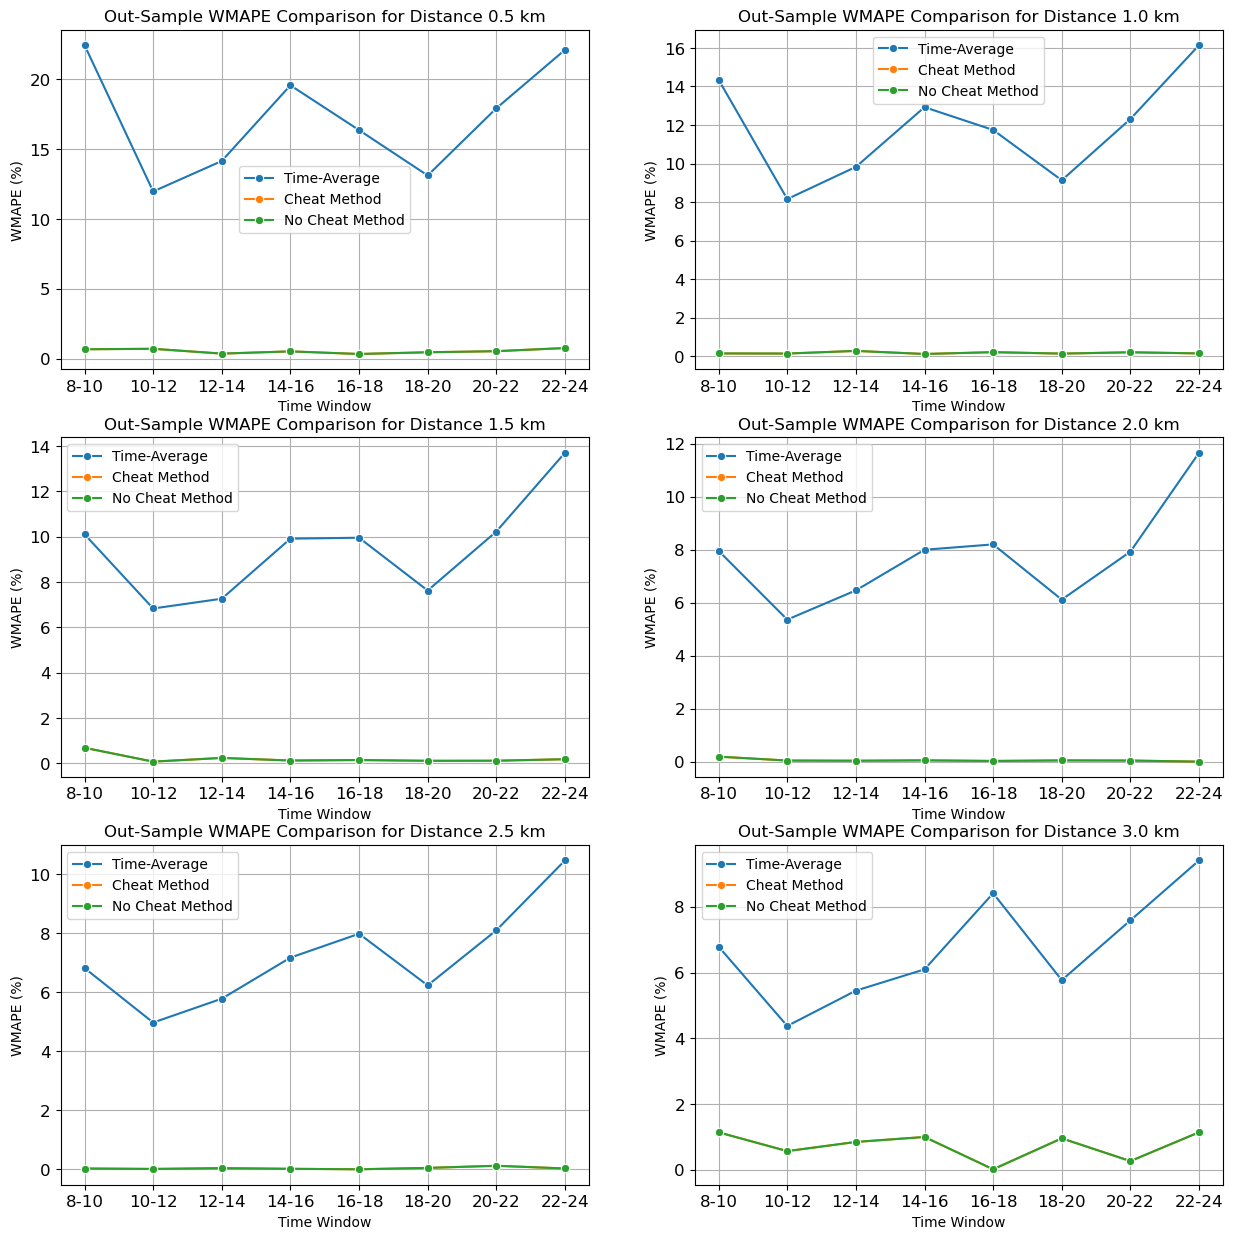

In [201]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()

for i, dpg in enumerate(distances):     
    subset = comparison_df[comparison_df['Distance'] == dpg]
    # check if wmape is in %
    sns.lineplot(x='Time Window', y='Time-Average Out WMAPE', data=subset, marker='o', label='Time-Average', ax=axes[i])
    sns.lineplot(x='Time Window', y='Cheat Method Combined Out WMAPE', data=subset, marker='o', label='Cheat Method', ax=axes[i])    
    sns.lineplot(x='Time Window', y='No Cheat Method Combined Out WMAPE', data=subset, marker='o', label='No Cheat Method', ax=axes[i])
    # sns.lineplot(x='Time Window', y='Cheat Method Out Assort Ratio', data=subset, marker='o', label='Cheat Method Assort Ratio', ax=axes[i])
    axes[i].set_title(f'Out-Sample WMAPE Comparison for Distance {dpg} km')
    axes[i].set_ylabel('WMAPE (%)')
    axes[i].set_xlabel('Time Window')
    axes[i].legend()
    axes[i].grid(True)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

In [6]:

# Create a DataFrame for comparison
comparison_df = pd.DataFrame()
distances = [
    0.5, 
    1.0, 
    1.5
    , 2.0, 2.5, 
    3.0
    # , 4.0, 5.0
    ]

time_windows = [
    # '00:00-01:59:59', '02:00-03:59:59', '04:00-05:59:59',
    # '08:00-09:59:59', '10:00-11:59:59', '12:00-13:59:59',
    # '14:00-15:59:59', '16:00-17:59:59', '18:00-19:59:59',
    # '20:00-21:59:59', '22:00-23:59:59'
    # '08:00-10:00', '10:00-12:00', '12:00-14:00',
    # '14:00-16:00', '16:00-18:00', '18:00-20:00',
    # '20:00-22:00', '22:00-23:59'
    '8-10', 
    '10-12', '12-14',
    '14-16', '16-18', '18-20',
    '20-22', '22-24'
]

for dpg in distances:
    if dpg in time_avg_results and dpg in cheat_results:
        # wmapes
        time_avg_out_wmapes = []
        cheat_out_wmapes = []
        no_cheat_out_wmapes = []
        
        time_avg_in_wmapes = []
        cheat_in_wmapes = []
        no_cheat_in_wmapes = []
        
        # relative errors
        time_avg_in_rela_errs = []
        cheat_in_rela_errs = []
        no_cheat_in_rela_errs = []

        time_avg_out_rela_errs = []
        cheat_out_rela_errs = []
        no_cheat_out_rela_errs = []
        
        # assort ratios
        time_avg_out_assort_ratios = []
        cheat_out_assort_ratios = []
        no_cheat_out_assort_ratios = []

        # empirical choice prob: 1-D arrary
        time_avg_in_o_ij_actual = []
        cheat_in_o_ij_actual = []
        no_cheat_in_o_ij_actual = []

        time_avg_out_o_ij_actual = []
        cheat_in_out_o_ij_actual = []
        no_cheat_out_o_ij_actual = []

        # expected choice prob: 1-D arrary
        time_avg_in_o_ij_hat = []
        cheat_in_o_ij_hat = []
        no_cheat_in_o_ij_hat = []

        time_avg_out_o_ij_hat = []
        cheat_in_out_o_ij_hat = []
        no_cheat_out_o_ij_hat = []

        # estimated order amount: matrix
        time_avg_in_N_hat = []
        cheat_in_N_hat = []
        no_cheat_in_N_hat = []

        time_avg_out_N_hat = []
        cheat_in_out_N_hat = []
        no_cheat_out_N_hat = []

        # observed order amount: matrix
        time_avg_in_N_actual = []
        cheat_in_in_N_actual = []
        no_cheat_in_N_actual = []

        time_avg_out_N_actual = []
        cheat_in_out_N_actual = []
        no_cheat_out_N_actual = []
        
        # out wmape of combined method
        cheat_our_out_wmapes = []
        no_cheat_our_out_wmapes = []

        # in_relative_errors = None
        # out_relative_errors = None
        # out_sample_assort_ratio = None
        # in_o_ij_actual = None
        # in_o_ij_hat = None
        # in_N_hat = None
        # in_N_actual = None
        # out_o_ij_actual = None
        # out_o_ij_hat = None
        # out_N_hat = None
        # out_N_actual = None

        for tw in time_windows:
            idx = time_windows.index(tw)
            d = list(cheat_results[1.0].keys())[idx]
            # cheat_results[1.0][d][0].out_sample_wmapes

            time_avg_result = time_avg_results[dpg][idx]
            time_avg_rela_result = time_avg_rela_results[dpg][idx]
            cheat_result = cheat_results[dpg][d][0]
            no_cheat_result = no_cheat_results[dpg][d][0]

            # Average out-sample WMAPE over testing dates
            time_avg_out_wmape = np.mean(list(time_avg_result.out_sample_wmapes.values()))
            cheat_out_wmape = np.mean(list(cheat_result.out_sample_wmapes.values()))
            no_cheat_out_wmape = np.mean(list(no_cheat_result.out_sample_wmapes.values()))

            time_avg_out_wmapes.append(time_avg_out_wmape)
            cheat_out_wmapes.append(cheat_out_wmape)
            no_cheat_out_wmapes.append(no_cheat_out_wmape)

            # Average in-sample WMAPE over training dates
            time_avg_in_wmape = np.mean(list(time_avg_result.in_sample_wmapes.values()))
            cheat_in_wmape = np.mean(list(cheat_result.in_sample_wmapes.values()))
            no_cheat_in_wmape = np.mean(list(no_cheat_result.in_sample_wmapes.values()))

            time_avg_in_wmapes.append(time_avg_in_wmape)
            cheat_in_wmapes.append(cheat_in_wmape)
            no_cheat_in_wmapes.append(no_cheat_in_wmape)

            # # Average out-sample relative errors over testing dates
            time_avg_out_rela_err = np.mean(list(time_avg_rela_result.out_relative_errors[0]) + list(time_avg_rela_result.out_relative_errors[1]))
            cheat_out_rela_err = np.mean(cheat_result.out_relative_errors)
            no_cheat_out_rela_err = np.mean(no_cheat_result.out_relative_errors)

            time_avg_out_rela_errs.append(time_avg_out_rela_err)
            cheat_out_rela_errs.append(cheat_out_rela_err)
            no_cheat_out_rela_errs.append(no_cheat_out_rela_err)

            # # Average in-sample relative errors over training dates
            time_avg_in_rela_err = np.mean(list(time_avg_rela_result.in_relative_errors[0]) + list(time_avg_rela_result.in_relative_errors[1]))
            cheat_in_rela_err = np.mean(list(cheat_result.in_relative_errors))
            no_cheat_in_rela_err = np.mean(list(no_cheat_result.in_relative_errors))

            time_avg_in_rela_errs.append(time_avg_in_rela_err)
            cheat_in_rela_errs.append(cheat_in_rela_err)
            no_cheat_in_rela_errs.append(no_cheat_in_rela_err)

            # # Average out-sample assort ratios over testing dates    
            cheat_out_assort = np.mean(list(cheat_result.out_sample_assort_ratio.values()))
            cheat_out_assort_ratios.append(cheat_out_assort)
            
            # combined method, out-sample WMAPE
            o_ij_avg = time_avg_rela_result.o_ij_avg[0]
            avg_custom = np.sum(o_ij_avg, axis=1)
            num_total_cells = o_ij_avg.shape[1]
            p_hat_no_cheat = no_cheat_result.p_hat
            N_avg_our_no_cheat = np.array([(avg_custom * p_hat_no_cheat[:, c]).sum() for c in range(num_total_cells)])

            N_act_1 = no_cheat_result.out_N_hat[list(no_cheat_result.out_N_hat.keys())[0]]
            N_act_2 = no_cheat_result.out_N_hat[list(no_cheat_result.out_N_hat.keys())[1]]
            wmape_no_cheat_1 = np.abs(N_avg_our_no_cheat - N_act_1).sum() / N_act_1.sum()
            wmape_no_cheat_2 = np.abs(N_avg_our_no_cheat - N_act_2).sum() / N_act_2.sum()
            wmape_no_cheat_mean = (wmape_cheat_1 + wmape_cheat_2) / 2

            p_hat_cheat = cheat_result.p_hat
            N_avg_our_cheat = np.array([(avg_custom * p_hat_cheat[:, c]).sum() for c in range(num_total_cells)])
            N_act_1 = cheat_result.out_N_hat[list(cheat_result.out_N_hat.keys())[0]]
            N_act_2 = cheat_result.out_N_hat[list(cheat_result.out_N_hat.keys())[1]]
            wmape_cheat_1 = np.abs(N_avg_our_cheat - N_act_1).sum() / N_act_1.sum() * 100
            wmape_cheat_2 = np.abs(N_avg_our_cheat - N_act_2).sum() / N_act_2.sum() * 100
            wmape_cheat_mean = (wmape_cheat_1 + wmape_cheat_2) / 2

            cheat_our_out_wmapes.append(wmape_cheat_mean)
            no_cheat_our_out_wmapes.append(wmape_no_cheat_mean)


            # Empirical choice probabilities for in-sample
            # keys = list(time_avg_rela_result.out_o_ij_actual.keys())
            # list(time_avg_rela_result.out_o_ij_actual[keys[0]].flatten()) + list(time_avg_rela_result.out_o_ij_actual[keys[1]].flatten()) 
            
            # time_avg_in_o_ij_actual.append(time_avg_result.in_o_ij_actual)
            # cheat_in_o_ij_actual.append(cheat_result.in_sample_o_ij_actual)
            # no_cheat_in_o_ij_actual.append(no_cheat_result.in_sample_o_ij_actual)

            # # Empirical choice probabilities for out-sample
            # # time_avg_out_o_ij_actual.append(time_avg_result.out_sample_o_ij_actual)
            # cheat_in_out_o_ij_actual.append(cheat_result.out_sample_o_ij_actual)
            # no_cheat_out_o_ij_actual.append(no_cheat_result.out_sample_o_ij_actual)

            # # Expected choice probabilities for in-sample
            # # time_avg_in_o_ij_hat.append(time_avg_result.in_sample_o_ij_hat)
            # cheat_in_o_ij_hat.append(cheat_result.in_sample_o_ij_hat)
            # no_cheat_in_o_ij_hat.append(no_cheat_result.in_sample_o_ij_hat)
            # # Expected choice probabilities for out-sample
            # # time_avg_out_o_ij_hat.append(time_avg_result.out_sample_o_ij_hat)
            # cheat_in_out_o_ij_hat.append(cheat_result.out_sample_o_ij_hat)
            # no_cheat_out_o_ij_hat.append(no_cheat_result.out_sample_o_ij_hat)

            # # Estimated order amount for in-sample
            # # time_avg_in_N_hat.append(time_avg_result.in_sample_N_hat)
            # cheat_in_N_hat.append(cheat_result.in_sample_N_hat)
            # no_cheat_in_N_hat.append(no_cheat_result.in_sample_N_hat)
            # # Estimated order amount for out-sample
            # # time_avg_out_N_hat.append(time_avg_result.out_sample_N_hat)
            # cheat_in_out_N_hat.append(cheat_result.out_sample_N_hat)
            # no_cheat_out_N_hat.append(no_cheat_result.out_sample_N_hat)
            # # Observed order amount for in-sample
            # # time_avg_in_N_actual.append(time_avg_result.in_sample_N_actual)
            # cheat_in_in_N_actual.append(cheat_result.in_sample_N_actual)
            # no_cheat_in_N_actual.append(no_cheat_result.in_sample_N_actual)
            # # Observed order amount for out-sample
            # # time_avg_out_N_actual.append(time_avg_result.out_sample_N_actual)
            # cheat_in_out_N_actual.append(cheat_result.out_sample_N_actual)
            # no_cheat_out_N_actual.append(no_cheat_result.out_sample_N_actual)

        temp_df = pd.DataFrame({
            'Distance': dpg,
            'Time Window': time_windows,
            'Time-Average Out WMAPE': time_avg_out_wmapes,
            'Cheat Method Out WMAPE': cheat_out_wmapes,
            'No Cheat Method Out WMAPE': no_cheat_out_wmapes,
            'Time-Average In WMAPE': time_avg_in_wmapes,
            'Cheat Method In WMAPE': cheat_in_wmapes,
            'No Cheat Method In WMAPE': no_cheat_in_wmapes,
            'Time-Average Out Relative Error': time_avg_out_rela_errs,
            'Cheat Method Out Relative Error': cheat_out_rela_errs,
            'No Cheat Method Out Relative Error': no_cheat_out_rela_errs,
            'Time-Average In Relative Error': time_avg_in_rela_errs,
            'Cheat Method In Relative Error': cheat_in_rela_errs,
            'No Cheat Method In Relative Error': no_cheat_in_rela_errs,
            'Cheat Method Out Assort Ratio': cheat_out_assort_ratios,
            'Cheat Method Combined Out WMAPE': cheat_our_out_wmapes,
            'No Cheat Method Combined Out WMAPE': no_cheat_our_out_wmapes

            # ,
            # 'Time-Average In WMAPE': time_avg_wmapes,
            # 'Cheat Method In WMAPE': cheat_wmapes,
            # 'No Cheat Method In WMAPE': no_cheat_wmapes
        })
        comparison_df = pd.concat([comparison_df, temp_df], ignore_index=True)


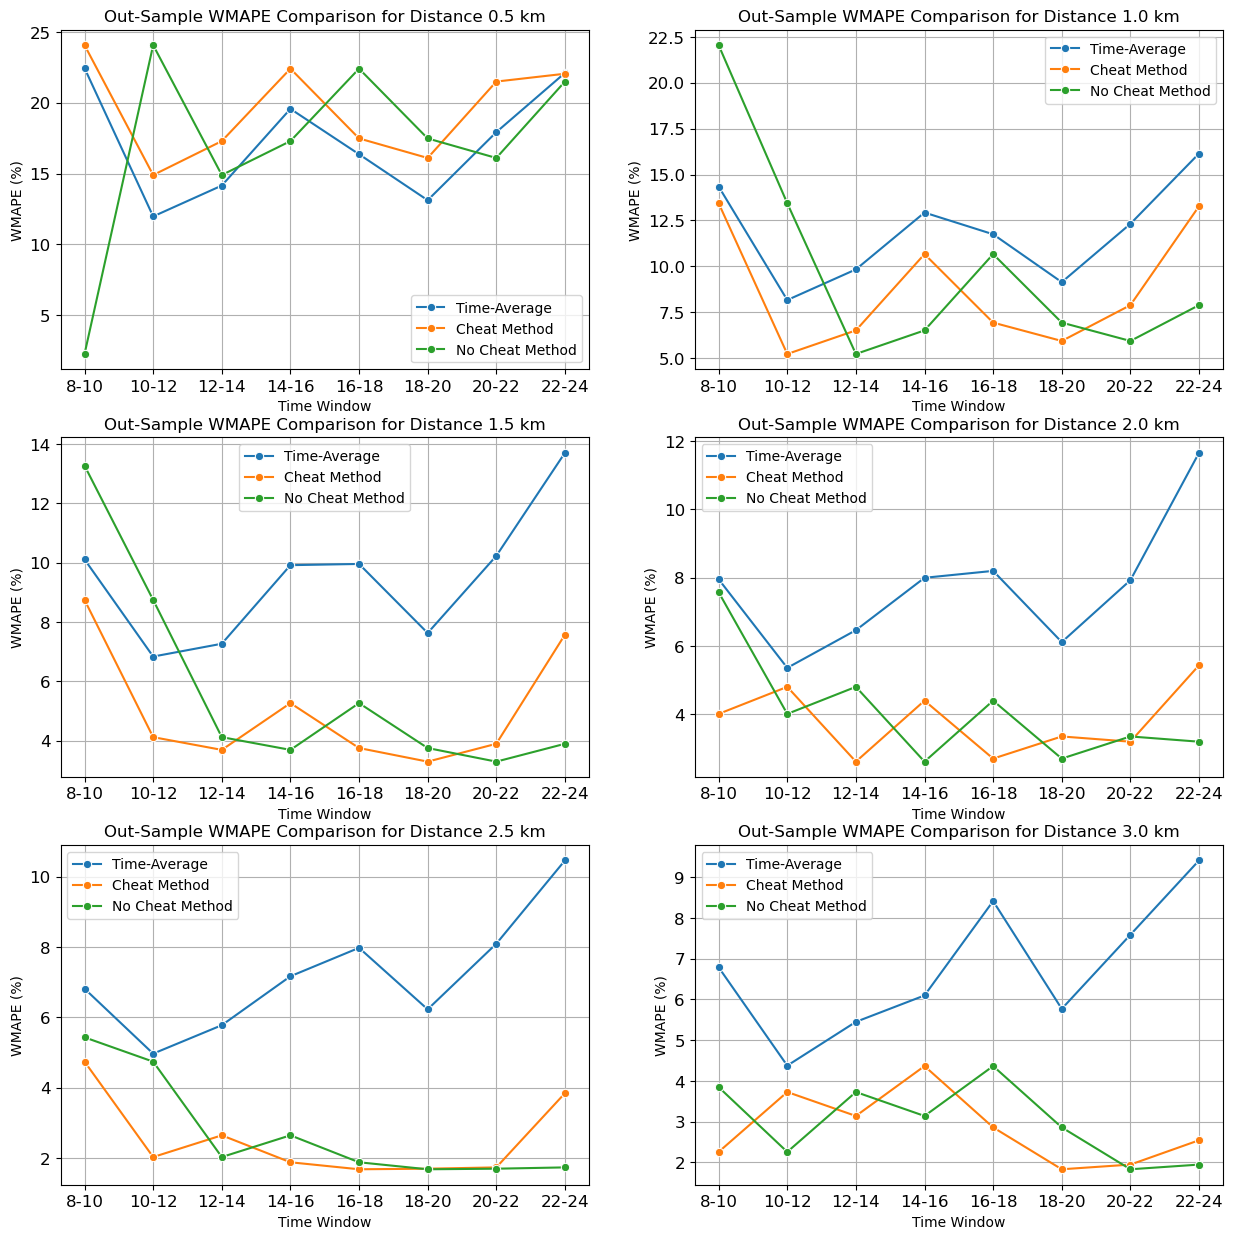

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()

for i, dpg in enumerate(distances):     
    subset = comparison_df[comparison_df['Distance'] == dpg]
    # check if wmape is in %
    sns.lineplot(x='Time Window', y='Time-Average Out WMAPE', data=subset, marker='o', label='Time-Average', ax=axes[i])
    sns.lineplot(x='Time Window', y='Cheat Method Combined Out WMAPE', data=subset, marker='o', label='Cheat Method', ax=axes[i])    
    sns.lineplot(x='Time Window', y='No Cheat Method Combined Out WMAPE', data=subset, marker='o', label='No Cheat Method', ax=axes[i])
    # sns.lineplot(x='Time Window', y='Cheat Method Out Assort Ratio', data=subset, marker='o', label='Cheat Method Assort Ratio', ax=axes[i])
    axes[i].set_title(f'Out-Sample WMAPE Comparison for Distance {dpg} km')
    axes[i].set_ylabel('WMAPE (%)')
    axes[i].set_xlabel('Time Window')
    axes[i].legend()
    axes[i].grid(True)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

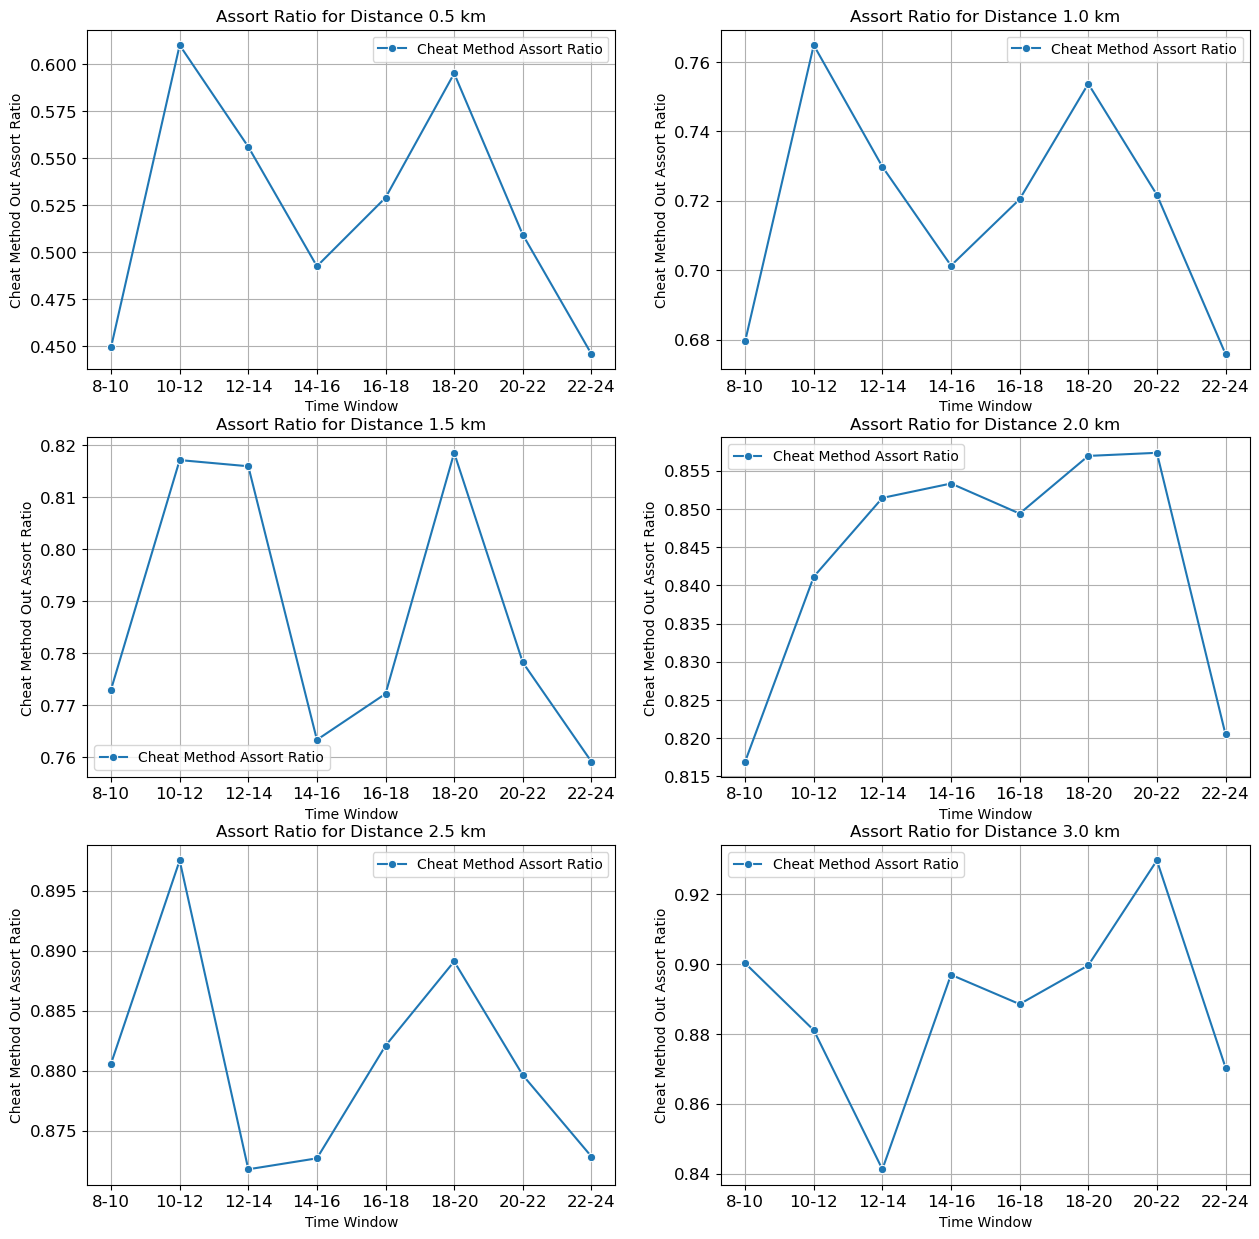

In [83]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()
comparison_df['Cheat Method Out Assort Ratio'] = comparison_df['Cheat Method Out Assort Ratio'] / 10
for i, dpg in enumerate(distances):     
    subset = comparison_df[comparison_df['Distance'] == dpg]
    sns.lineplot(x='Time Window', y='Cheat Method Out Assort Ratio', data=subset, marker='o', label='Cheat Method Assort Ratio', ax=axes[i])
    axes[i].set_title(f'Assort Ratio for Distance {dpg} km')
    # axes[i].set_ylabel('WMAPE (%)')
    axes[i].set_xlabel('Time Window')
    axes[i].legend()
    axes[i].grid(True)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

In [71]:
time_windows = [
    # '00:00-01:59:59', '02:00-03:59:59', '04:00-05:59:59',
    # '08:00-09:59:59', '10:00-11:59:59', '12:00-13:59:59',
    # '14:00-15:59:59', '16:00-17:59:59', '18:00-19:59:59',
    # '20:00-21:59:59', '22:00-23:59:59'
    # '08:00-10:00', '10:00-12:00', '12:00-14:00',
    # '14:00-16:00', '16:00-18:00', '18:00-20:00',
    # '20:00-22:00', '22:00-23:59'
    '8-10'
    # , '10-12', '12-14',
    # '14-16', '16-18', '18-20',
    # '20-22', '22-24'
]

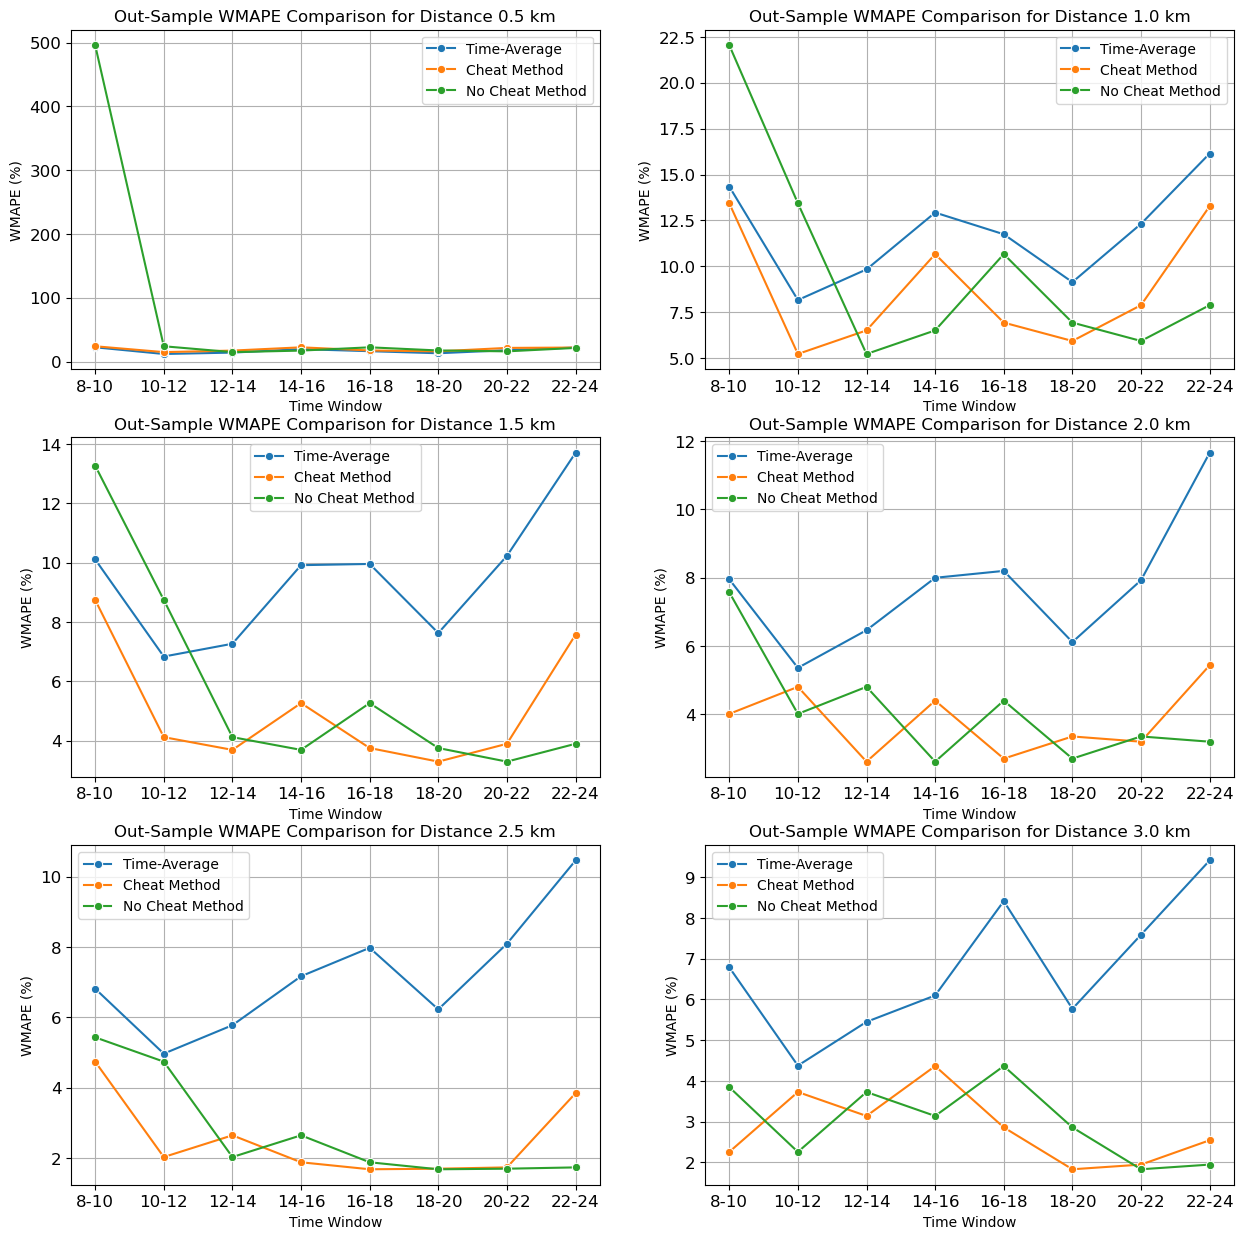

In [72]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()
for i, dpg in enumerate(distances):     
    subset = comparison_df[comparison_df['Distance'] == dpg]
    sns.lineplot(x='Time Window', y='Time-Average Out WMAPE', data=subset, marker='o', label='Time-Average', ax=axes[i])
    sns.lineplot(x='Time Window', y='Cheat Method Combined Out WMAPE', data=subset, marker='o', label='Cheat Method', ax=axes[i])    
    sns.lineplot(x='Time Window', y='No Cheat Method Combined Out WMAPE', data=subset, marker='o', label='No Cheat Method', ax=axes[i])
    axes[i].set_title(f'Out-Sample WMAPE Comparison for Distance {dpg} km')
    axes[i].set_ylabel('WMAPE (%)')
    axes[i].set_xlabel('Time Window')
    axes[i].legend()
    axes[i].grid(True)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

# WMAPE Comparision

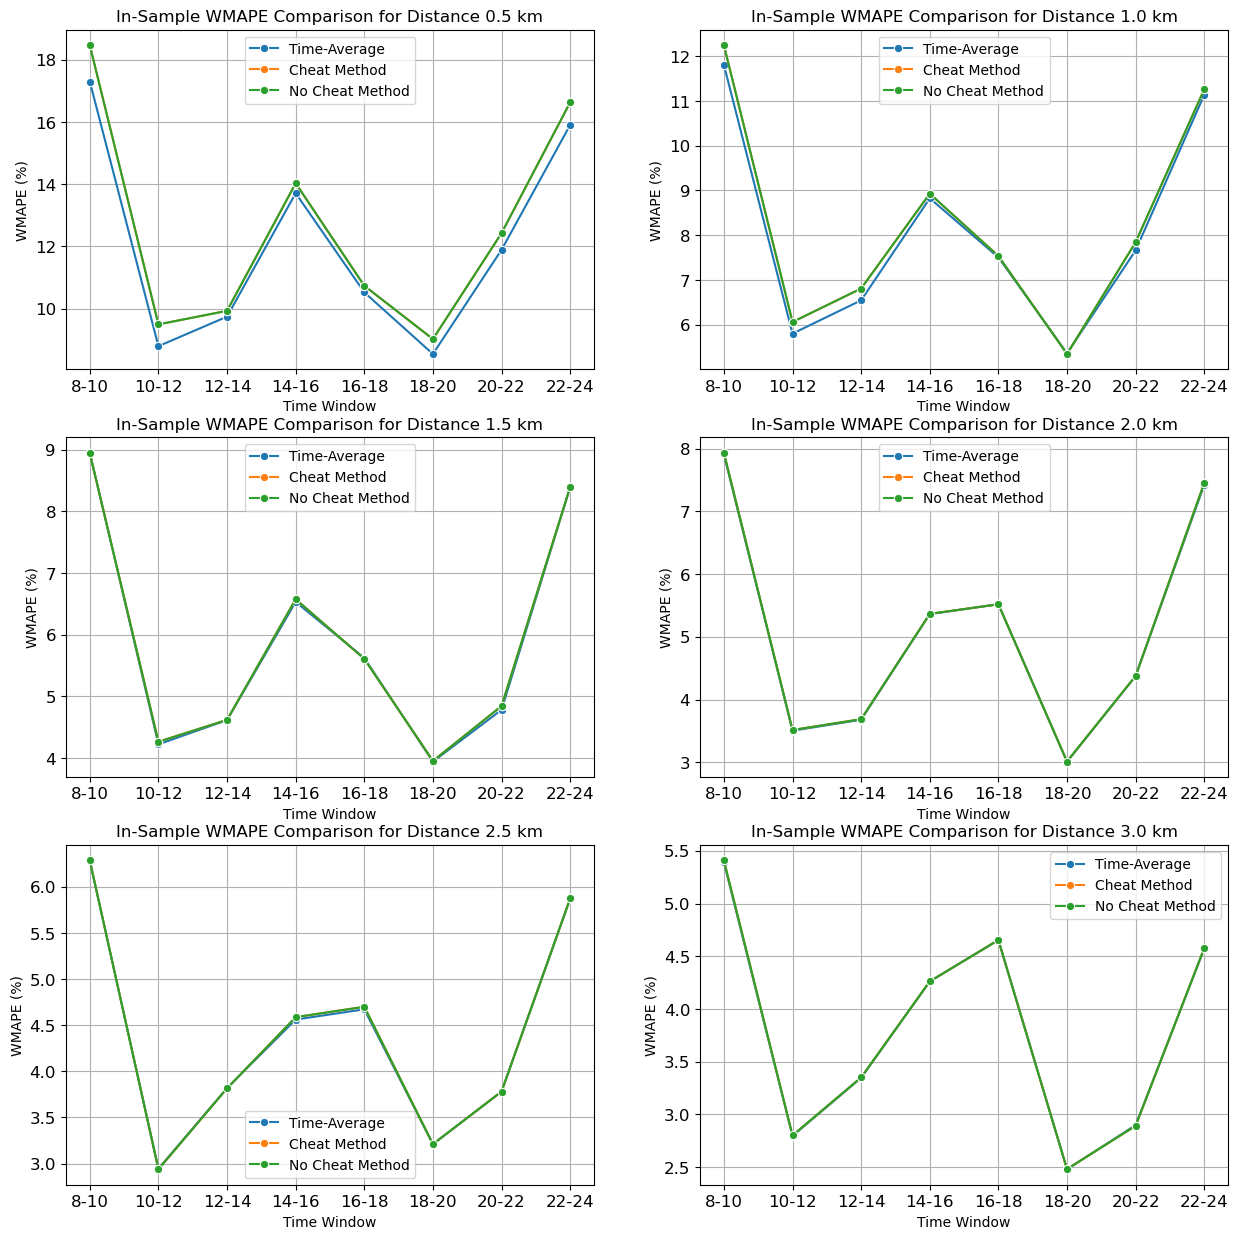

In [5]:

# # Visualize comparison for each distance
# for dpg in distances:
#     lab_size = 15
#     font_size = 15
#     plt.figure(figsize=(8, 6))
#     subset = comparison_df[comparison_df['Distance'] == dpg]
#     sns.lineplot(x='Time Window', y='Time-Average In WMAPE', data=subset, marker='o', label='Time-Average')
#     sns.lineplot(x='Time Window', y='Cheat Method In WMAPE', data=subset, marker='o', label='Cheat Method')    
#     sns.lineplot(x='Time Window', y='No Cheat Method In WMAPE', data=subset, marker='o', label='No Cheat Method')
#     # sns.lineplot(x='Time Window', y='Time-Average WMAPE', data=subset, marker='o', label='Time-Average')
#     # sns.lineplot(x='Time Window', y='Cheat Method WMAPE', data=subset, marker='o', label='Cheat Method')
#     # sns.lineplot(x='Time Window', y='No Cheat Method WMAPE', data=subset, marker='o', label='No Cheat Method')
#     plt.title(f'In-Sample WMAPE Comparison for Distance {dpg} km', fontsize=lab_size)
#     # enlarge the y axis font
#     plt.yticks(fontsize=font_size)
#     plt.xticks(rotation=45)
#     plt.ylabel('WMAPE (%)', fontsize=font_size)
#     plt.xlabel('Time Window', fontsize=font_size)
#     plt.legend()
#     plt.tight_layout()
#     plt.grid(True)
#     # plt.savefig(f'2h_fix_Assort/results3_5km/comparison_in_dpg_{dpg}.png')
#     plt.show()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()
for i, dpg in enumerate(distances):     
    subset = comparison_df[comparison_df['Distance'] == dpg]
    sns.lineplot(x='Time Window', y='Time-Average In WMAPE', data=subset, marker='o', label='Time-Average', ax=axes[i])
    sns.lineplot(x='Time Window', y='Cheat Method In WMAPE', data=subset, marker='o', label='Cheat Method', ax=axes[i])    
    sns.lineplot(x='Time Window', y='No Cheat Method In WMAPE', data=subset, marker='o', label='No Cheat Method', ax=axes[i])
    axes[i].set_title(f'In-Sample WMAPE Comparison for Distance {dpg} km')
    axes[i].set_ylabel('WMAPE (%)')
    axes[i].set_xlabel('Time Window')
    axes[i].legend()
    axes[i].grid(True)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

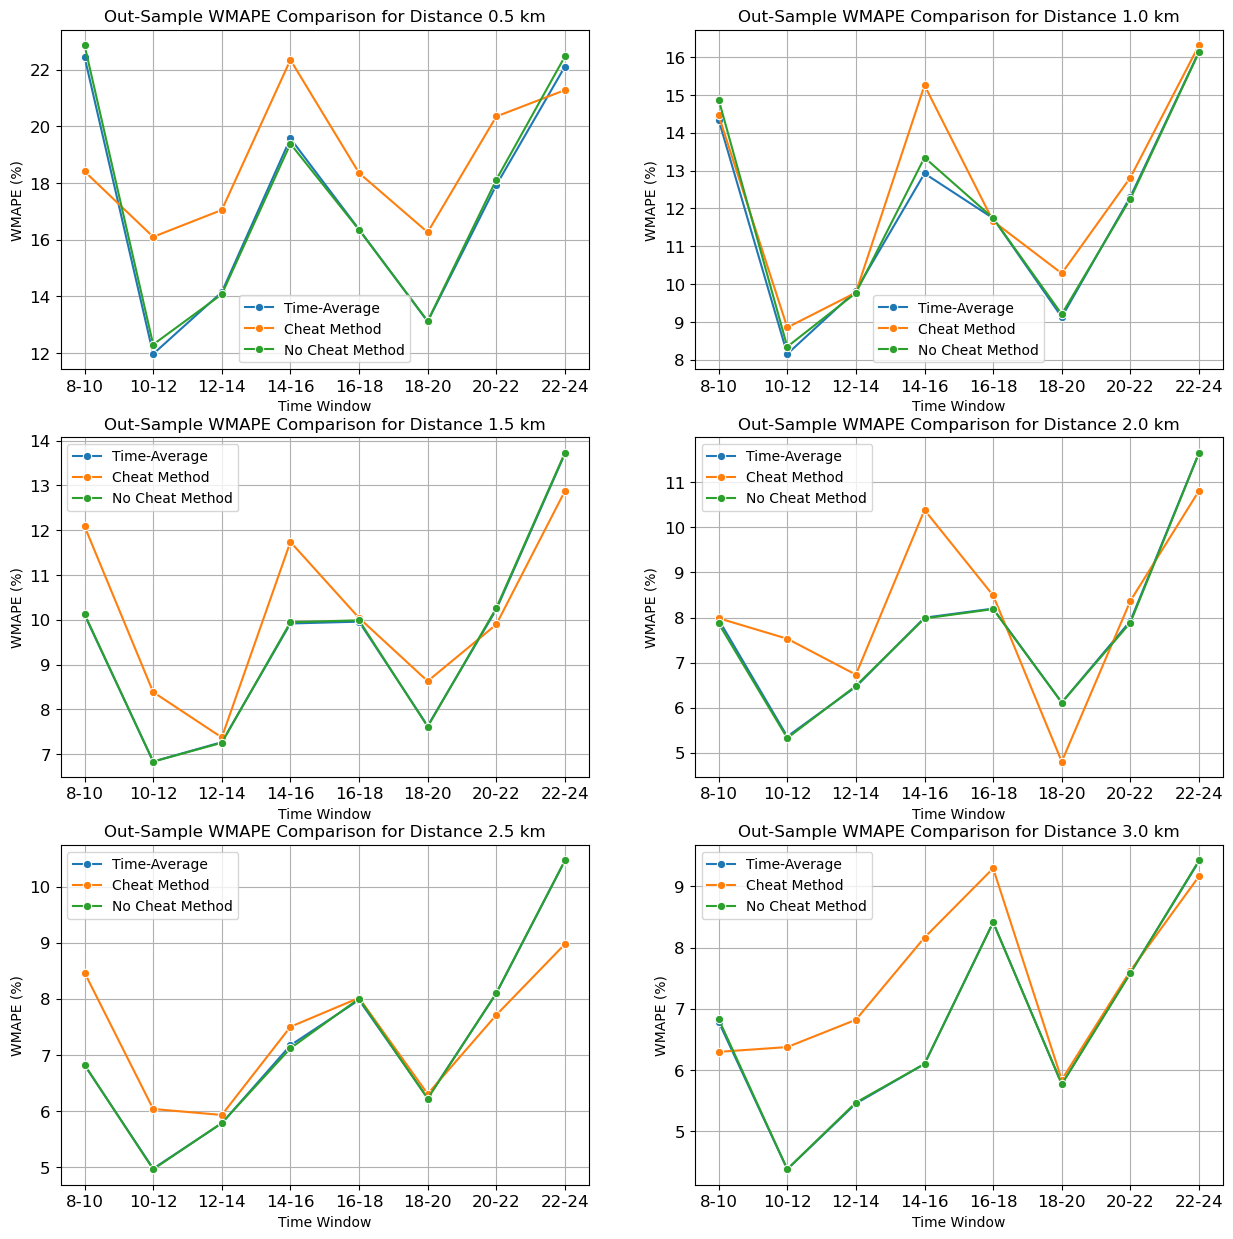

In [6]:

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()
for i, dpg in enumerate(distances):     
    subset = comparison_df[comparison_df['Distance'] == dpg]
    sns.lineplot(x='Time Window', y='Time-Average Out WMAPE', data=subset, marker='o', label='Time-Average', ax=axes[i])
    sns.lineplot(x='Time Window', y='Cheat Method Out WMAPE', data=subset, marker='o', label='Cheat Method', ax=axes[i])    
    sns.lineplot(x='Time Window', y='No Cheat Method Out WMAPE', data=subset, marker='o', label='No Cheat Method', ax=axes[i])
    axes[i].set_title(f'Out-Sample WMAPE Comparison for Distance {dpg} km')
    axes[i].set_ylabel('WMAPE (%)')
    axes[i].set_xlabel('Time Window')
    axes[i].legend()
    axes[i].grid(True)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

## Why cheat method is worse than no-cheat method? 
- training assort larger than testing assort
- how does them distributed?

In [14]:
comparison_df['Diff In WMAPE'] = (comparison_df['Cheat Method Out WMAPE'] - comparison_df['No Cheat Method Out WMAPE'])/ comparison_df['No Cheat Method Out WMAPE']
comparison_df['Diff In WMAPE (%)'] = (comparison_df['Cheat Method Out WMAPE'] - comparison_df['No Cheat Method Out WMAPE'])/ comparison_df['No Cheat Method Out WMAPE']


# compare trend between assort ratio & out sample WMAPE

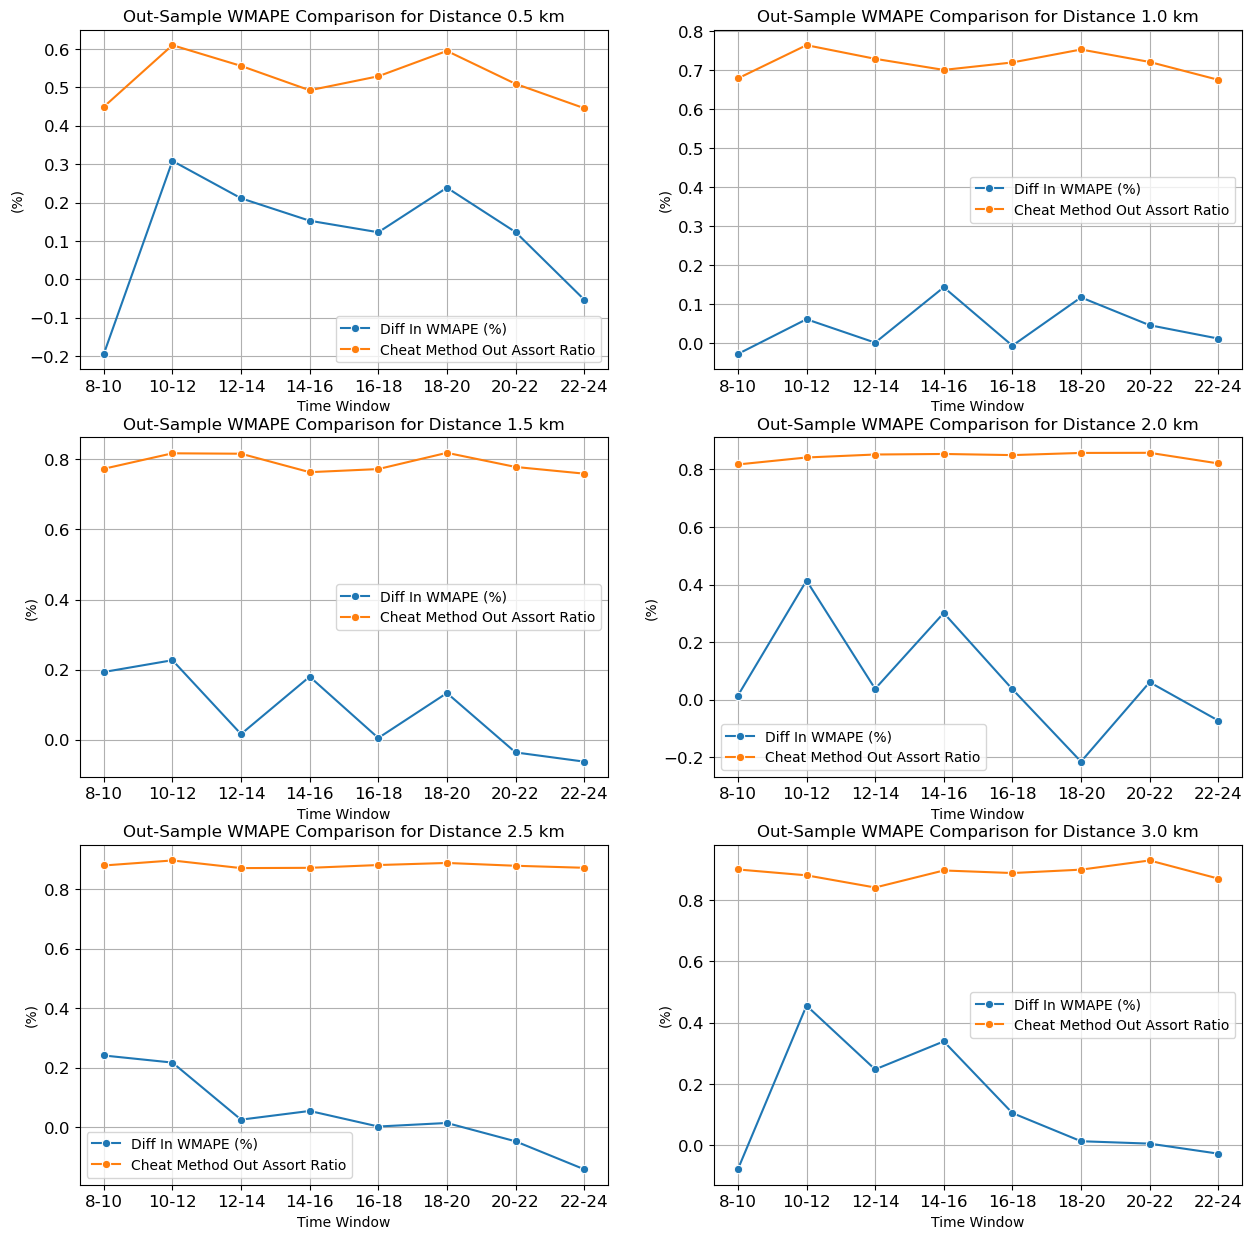

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()
for i, dpg in enumerate(distances):     
    subset = comparison_df[comparison_df['Distance'] == dpg]
    sns.lineplot(x='Time Window', y='Diff In WMAPE (%)', data=subset, marker='o', label='Diff In WMAPE (%)', ax=axes[i])
    sns.lineplot(x='Time Window', y='Cheat Method Out Assort Ratio', data=subset, marker='o', label='Cheat Method Out Assort Ratio', ax=axes[i])    
    # sns.lineplot(x='Time Window', y='No Cheat Method Out WMAPE', data=subset, marker='o', label='No Cheat Method', ax=axes[i])
    axes[i].set_title(f'Out-Sample WMAPE Comparison for Distance {dpg} km')
    axes[i].set_ylabel('(%)')
    axes[i].set_xlabel('Time Window')
    axes[i].legend()
    axes[i].grid(True)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

/tmp/ipykernel_3728825/684258314.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Diff In WMAPE (Normalized)'] = (subset['Diff In WMAPE'] - subset['Diff In WMAPE'].min())/ (subset['Diff In WMAPE'].max() - subset['Diff In WMAPE'].min())
/tmp/ipykernel_3728825/684258314.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cheat Method Out Assort Ratio (Normalized)'] = (subset['Cheat Method Out Assort Ratio'] - subset['Cheat Method Out Assort Ratio'].min()) / (subset['Cheat Method Out Assort 

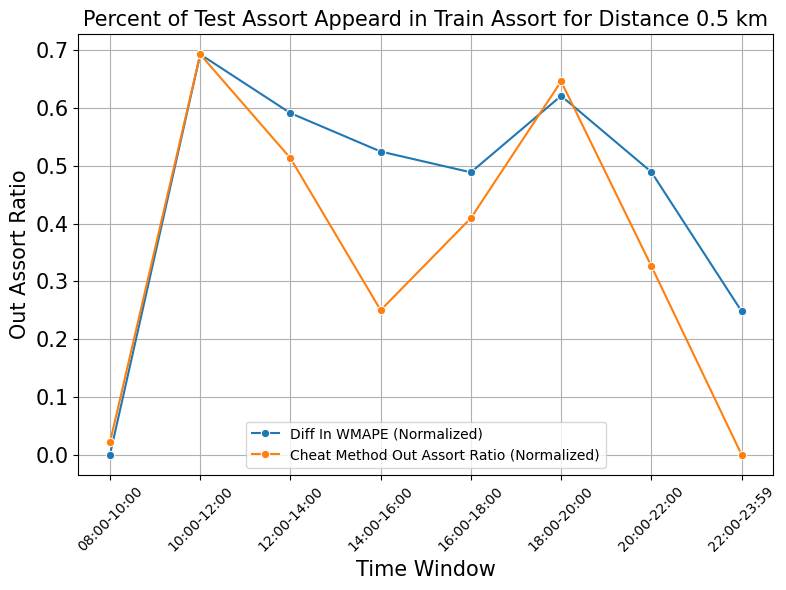

/tmp/ipykernel_3728825/684258314.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Diff In WMAPE (Normalized)'] = (subset['Diff In WMAPE'] - subset['Diff In WMAPE'].min())/ (subset['Diff In WMAPE'].max() - subset['Diff In WMAPE'].min())
/tmp/ipykernel_3728825/684258314.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cheat Method Out Assort Ratio (Normalized)'] = (subset['Cheat Method Out Assort Ratio'] - subset['Cheat Method Out Assort Ratio'].min()) / (subset['Cheat Method Out Assort 

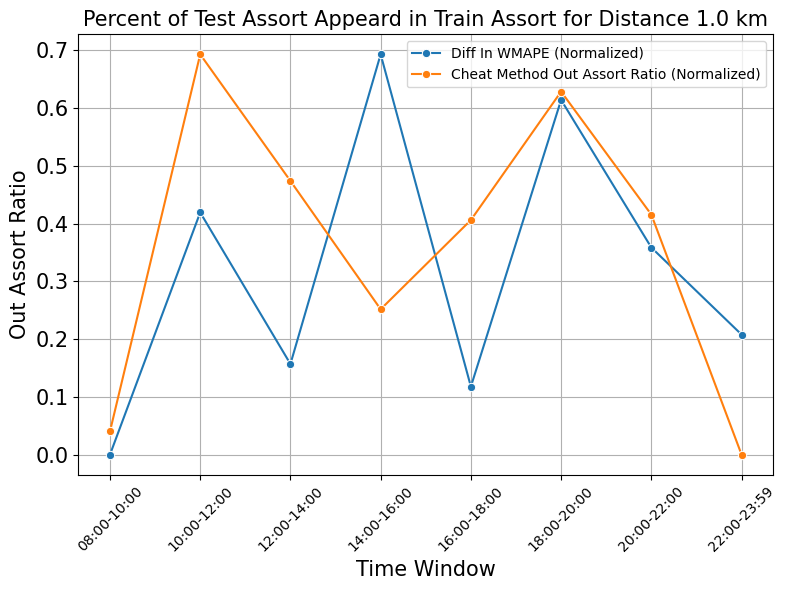

/tmp/ipykernel_3728825/684258314.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Diff In WMAPE (Normalized)'] = (subset['Diff In WMAPE'] - subset['Diff In WMAPE'].min())/ (subset['Diff In WMAPE'].max() - subset['Diff In WMAPE'].min())
/tmp/ipykernel_3728825/684258314.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cheat Method Out Assort Ratio (Normalized)'] = (subset['Cheat Method Out Assort Ratio'] - subset['Cheat Method Out Assort Ratio'].min()) / (subset['Cheat Method Out Assort 

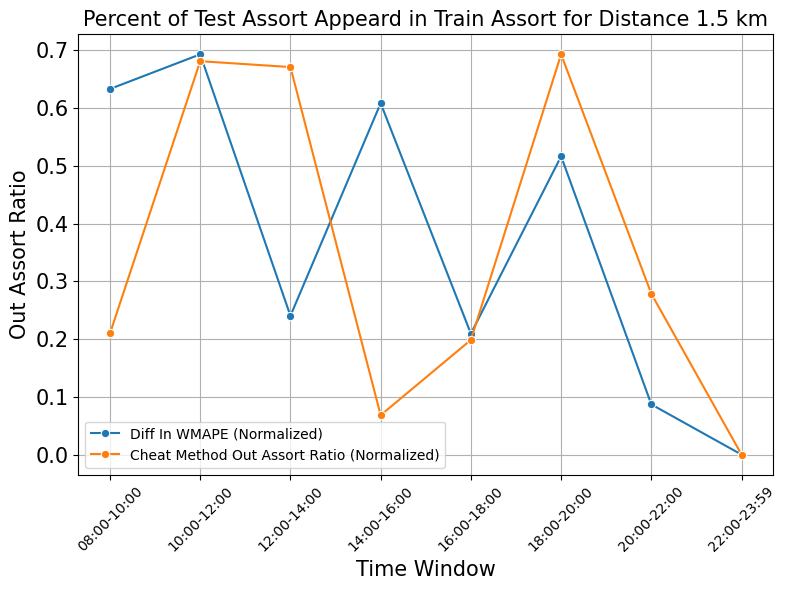

/tmp/ipykernel_3728825/684258314.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Diff In WMAPE (Normalized)'] = (subset['Diff In WMAPE'] - subset['Diff In WMAPE'].min())/ (subset['Diff In WMAPE'].max() - subset['Diff In WMAPE'].min())
/tmp/ipykernel_3728825/684258314.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cheat Method Out Assort Ratio (Normalized)'] = (subset['Cheat Method Out Assort Ratio'] - subset['Cheat Method Out Assort Ratio'].min()) / (subset['Cheat Method Out Assort 

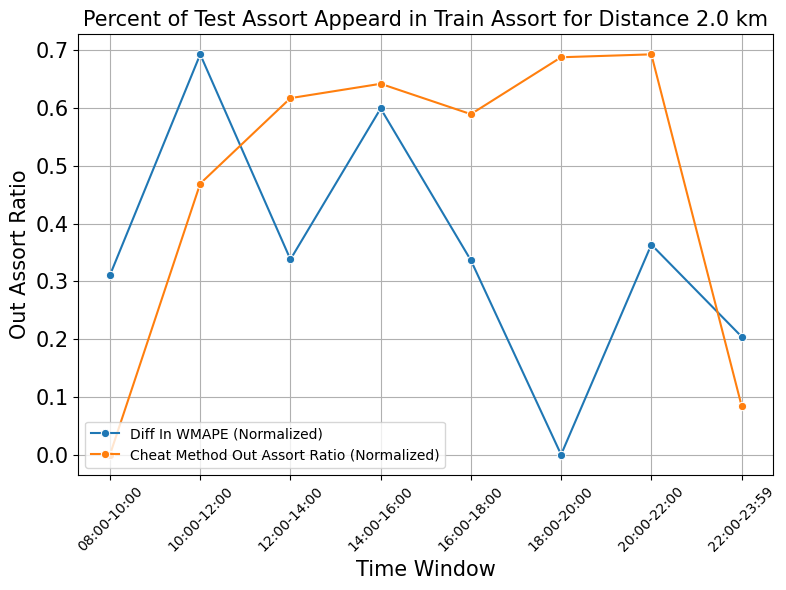

/tmp/ipykernel_3728825/684258314.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Diff In WMAPE (Normalized)'] = (subset['Diff In WMAPE'] - subset['Diff In WMAPE'].min())/ (subset['Diff In WMAPE'].max() - subset['Diff In WMAPE'].min())
/tmp/ipykernel_3728825/684258314.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cheat Method Out Assort Ratio (Normalized)'] = (subset['Cheat Method Out Assort Ratio'] - subset['Cheat Method Out Assort Ratio'].min()) / (subset['Cheat Method Out Assort 

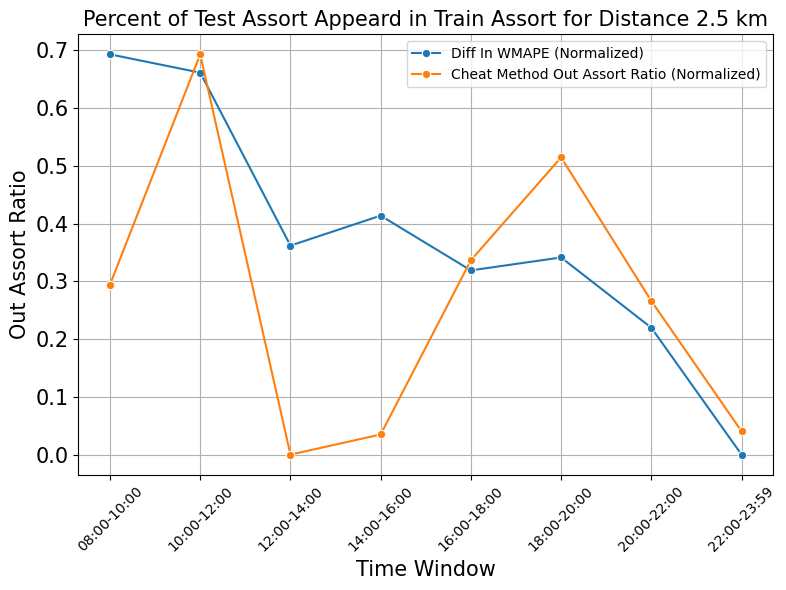

/tmp/ipykernel_3728825/684258314.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Diff In WMAPE (Normalized)'] = (subset['Diff In WMAPE'] - subset['Diff In WMAPE'].min())/ (subset['Diff In WMAPE'].max() - subset['Diff In WMAPE'].min())
/tmp/ipykernel_3728825/684258314.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Cheat Method Out Assort Ratio (Normalized)'] = (subset['Cheat Method Out Assort Ratio'] - subset['Cheat Method Out Assort Ratio'].min()) / (subset['Cheat Method Out Assort 

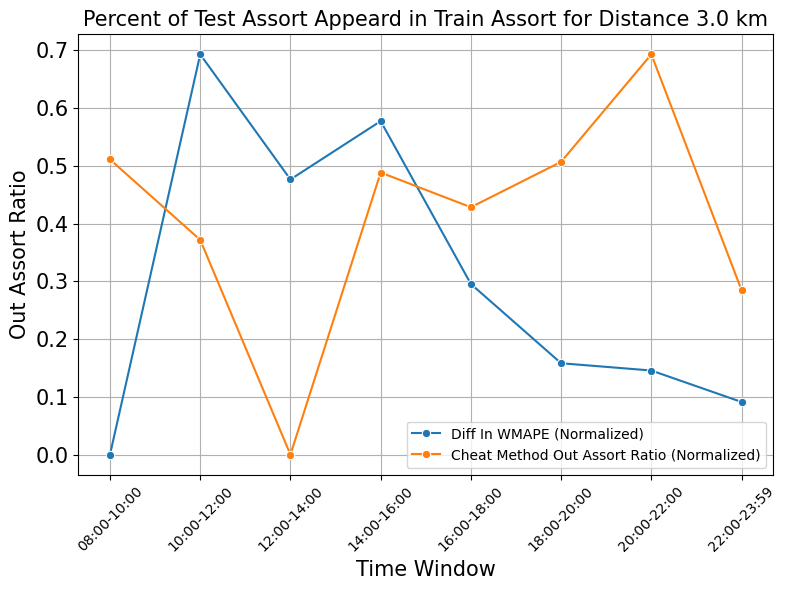

In [14]:

# plot cheat method out assort ratio changing with time window
for dpg in distances:
    lab_size = 15
    font_size = 15
    plt.figure(figsize=(8, 6))
    subset = comparison_df[comparison_df['Distance'] == dpg]
    # normalize the cheat method out assort ratio to 0-1
    subset['Diff In WMAPE (Normalized)'] = (subset['Diff In WMAPE'] - subset['Diff In WMAPE'].min())/ (subset['Diff In WMAPE'].max() - subset['Diff In WMAPE'].min())
    subset['Cheat Method Out Assort Ratio (Normalized)'] = (subset['Cheat Method Out Assort Ratio'] - subset['Cheat Method Out Assort Ratio'].min()) / (subset['Cheat Method Out Assort Ratio'].max() - subset['Cheat Method Out Assort Ratio'].min())
    
    subset['Diff In WMAPE (Log Normalized)'] = np.log1p(subset['Diff In WMAPE (Normalized)'])
    subset['Cheat Method Out Assort Ratio (Log Normalized)'] = np.log1p(subset['Cheat Method Out Assort Ratio (Normalized)'])
    
    # subset['Cheat Method Out Assort Ratio'] = subset['Cheat Method Out Assort Ratio'] / subset['Cheat Method Out Assort Ratio'].max()
    sns.lineplot(x='Time Window', y='Diff In WMAPE (Log Normalized)', data=subset, marker='o', label='Diff In WMAPE (Normalized)')
    sns.lineplot(x='Time Window', y='Cheat Method Out Assort Ratio (Log Normalized)', data=subset, marker='o', label='Cheat Method Out Assort Ratio (Normalized)')

    # normalize the y axis to 0-1

    # sns.lineplot(x='Time Window', y='No Cheat Method Out Assort Ratio', data=subset, marker='o', label='No Cheat Method Out Assort Ratio')        
    plt.title(f'Percent of Test Assort Appeard in Train Assort for Distance {dpg} km', fontsize=lab_size)
    # enlarge the y axis font
    plt.yticks(fontsize=font_size)
    plt.xticks(rotation=45)
    plt.ylabel('Out Assort Ratio', fontsize=font_size)
    plt.xlabel('Time Window', fontsize=font_size)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    # plt.savefig(f'2h_fix_Assort/results3_5km/comparison_in_dpg_{dpg}.png')
    plt.show()



Conclustion: 
- most time, cheat method worse than no cheat method (yellow line is above 0 at most times)
- with small grid size, higher hit ratio, cheat method worser 

# Relative Errors Comparison

In [5]:
comparison_df.head()

Distance  Time Window  Time-Average Out WMAPE  Cheat Method Out WMAPE  \
0       0.5  08:00-10:00               22.446497               18.410738   
1       0.5  10:00-12:00               11.972432               16.101622   
2       0.5  12:00-14:00               14.153568               17.050130   
3       0.5  14:00-16:00               19.572049               22.342849   
4       0.5  16:00-18:00               16.365426               18.353989   

   No Cheat Method Out WMAPE  Time-Average In WMAPE  Cheat Method In WMAPE  \
0                  22.860851              17.298390              18.467838   
1                  12.305661               8.789666               9.490778   
2                  14.078319               9.740029               9.926902   
3                  19.384652              13.708604              14.027648   
4                  16.350451              10.521670              10.733197   

   No Cheat Method In WMAPE  Time-Average Out Relative Error  \
0                 18.467838                         0.000598   
1                  9.490778                         0.000595   
2                  9.926902                         0.000611   
3                 14.027648                         0.000599   
4                 10.733197                         0.000634   

   Cheat Method Out Relative Error  No Cheat Method Out Relative Error  \
0                         0.000083                            0.000593   
1                         0.000180                            0.000583   
2                         0.000152                            0.000595   
3                         0.000117                            0.000590   
4                         0.000155                            0.000621   

   Time-Average In Relative Error  Cheat Method In Relative Error  \
0                        0.000385                        0.000410   
1                        0.000391                        0.000440   
2                        0.000398                        0.000440   
3                        0.000380                        0.000411   
4                        0.000419                        0.000452   

   No Cheat Method In Relative Error  Cheat Method Out Assort Ratio  
0                           0.000410                       0.449484  
1                           0.000440                       0.610127  
2                           0.000440                       0.556069  
3                           0.000411                       0.492575  
4                           0.000452                       0.529032

In Relative Error

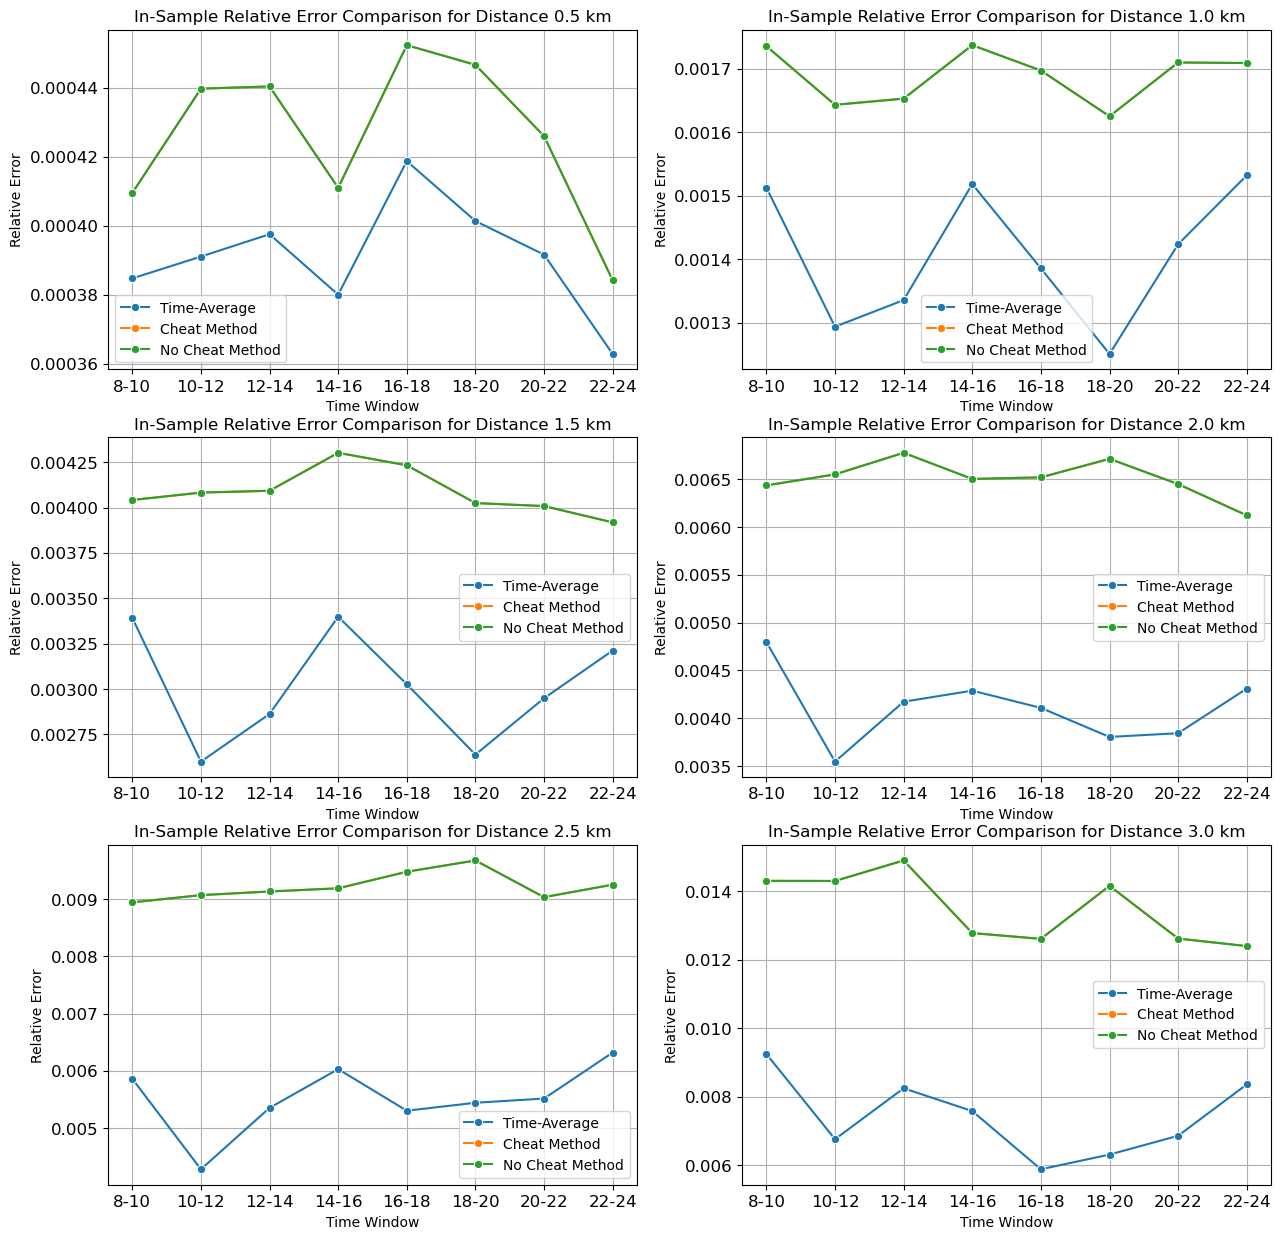

In [16]:

# combine all pictures together, with 2 columns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()
for i, dpg in enumerate(distances):     
    subset = comparison_df[comparison_df['Distance'] == dpg]
    sns.lineplot(x='Time Window', y='Time-Average In Relative Error', data=subset, marker='o', label='Time-Average', ax=axes[i])
    sns.lineplot(x='Time Window', y='Cheat Method In Relative Error', data=subset, marker='o', label='Cheat Method', ax=axes[i])    
    sns.lineplot(x='Time Window', y='No Cheat Method In Relative Error', data=subset, marker='o', label='No Cheat Method', ax=axes[i])
    axes[i].set_title(f'In-Sample Relative Error Comparison for Distance {dpg} km')
    axes[i].set_ylabel('Relative Error')
    axes[i].set_xlabel('Time Window')
    axes[i].legend()
    axes[i].grid(True)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

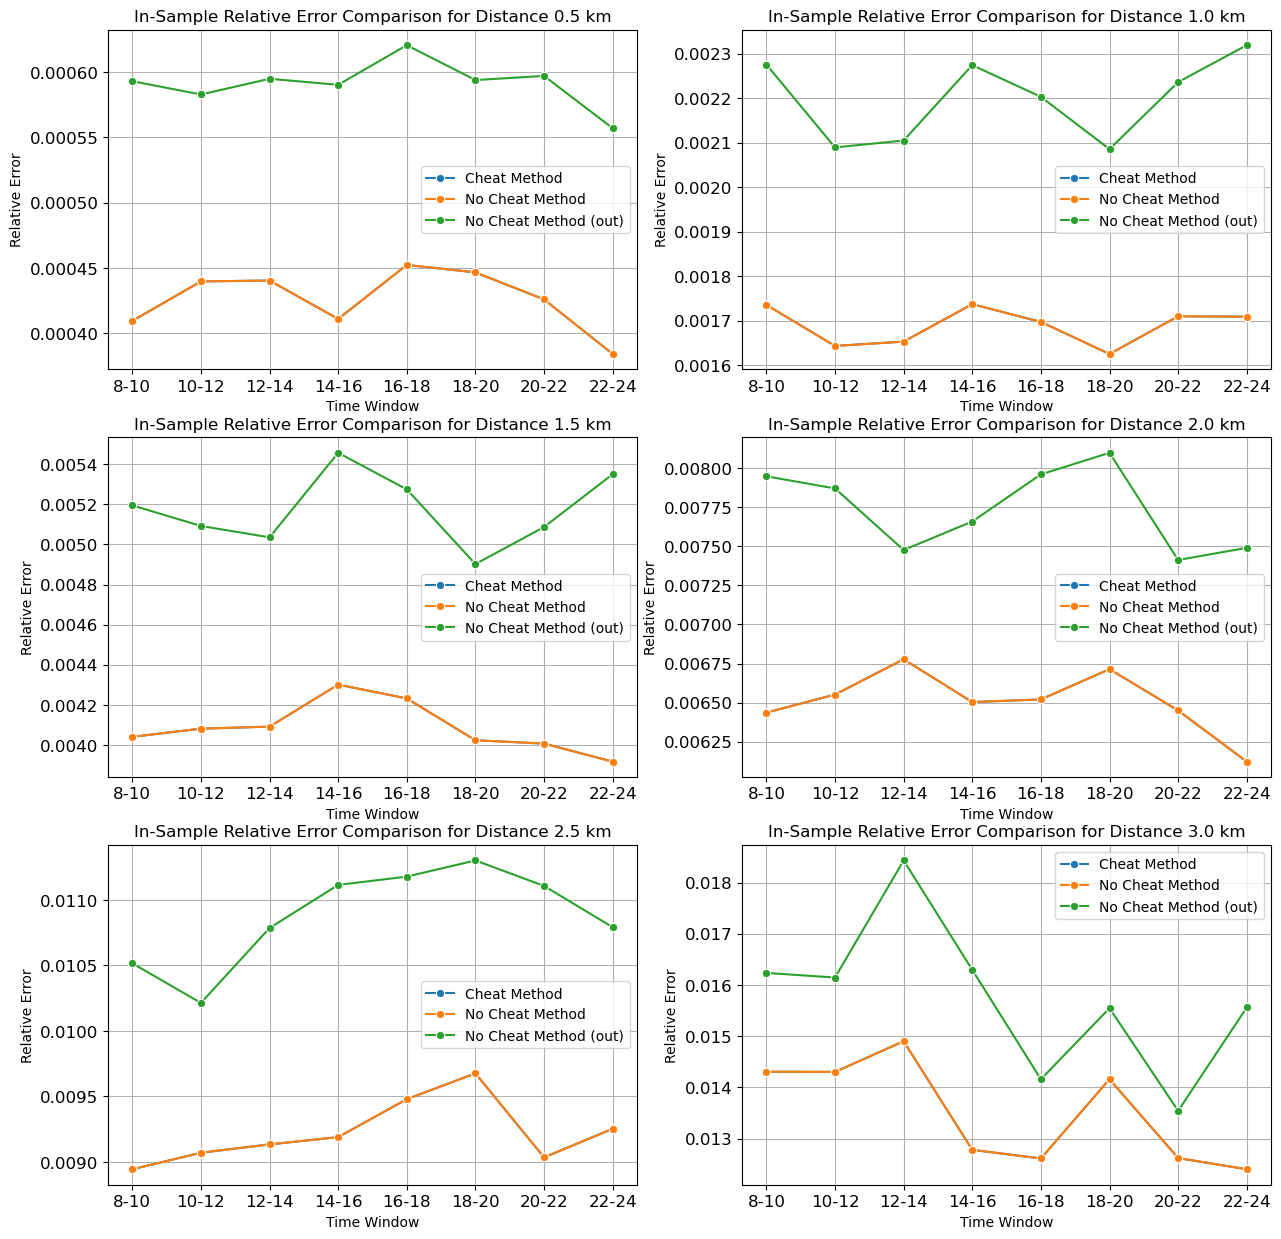

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()
for i, dpg in enumerate(distances):     
    subset = comparison_df[comparison_df['Distance'] == dpg]
    # sns.lineplot(x='Time Window', y='Time-Average In Relative Error', data=subset, marker='o', label='Time-Average', ax=axes[i])
    sns.lineplot(x='Time Window', y='Cheat Method In Relative Error', data=subset, marker='o', label='Cheat Method', ax=axes[i])    
    sns.lineplot(x='Time Window', y='No Cheat Method In Relative Error', data=subset, marker='o', label='No Cheat Method', ax=axes[i])
    sns.lineplot(x='Time Window', y='No Cheat Method Out Relative Error', data=subset, marker='o', label='No Cheat Method (out)', ax=axes[i])

    axes[i].set_title(f'In-Sample Relative Error Comparison for Distance {dpg} km')
    axes[i].set_ylabel('Relative Error')
    axes[i].set_xlabel('Time Window')
    axes[i].legend()
    axes[i].grid(True)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

Out Relative Error

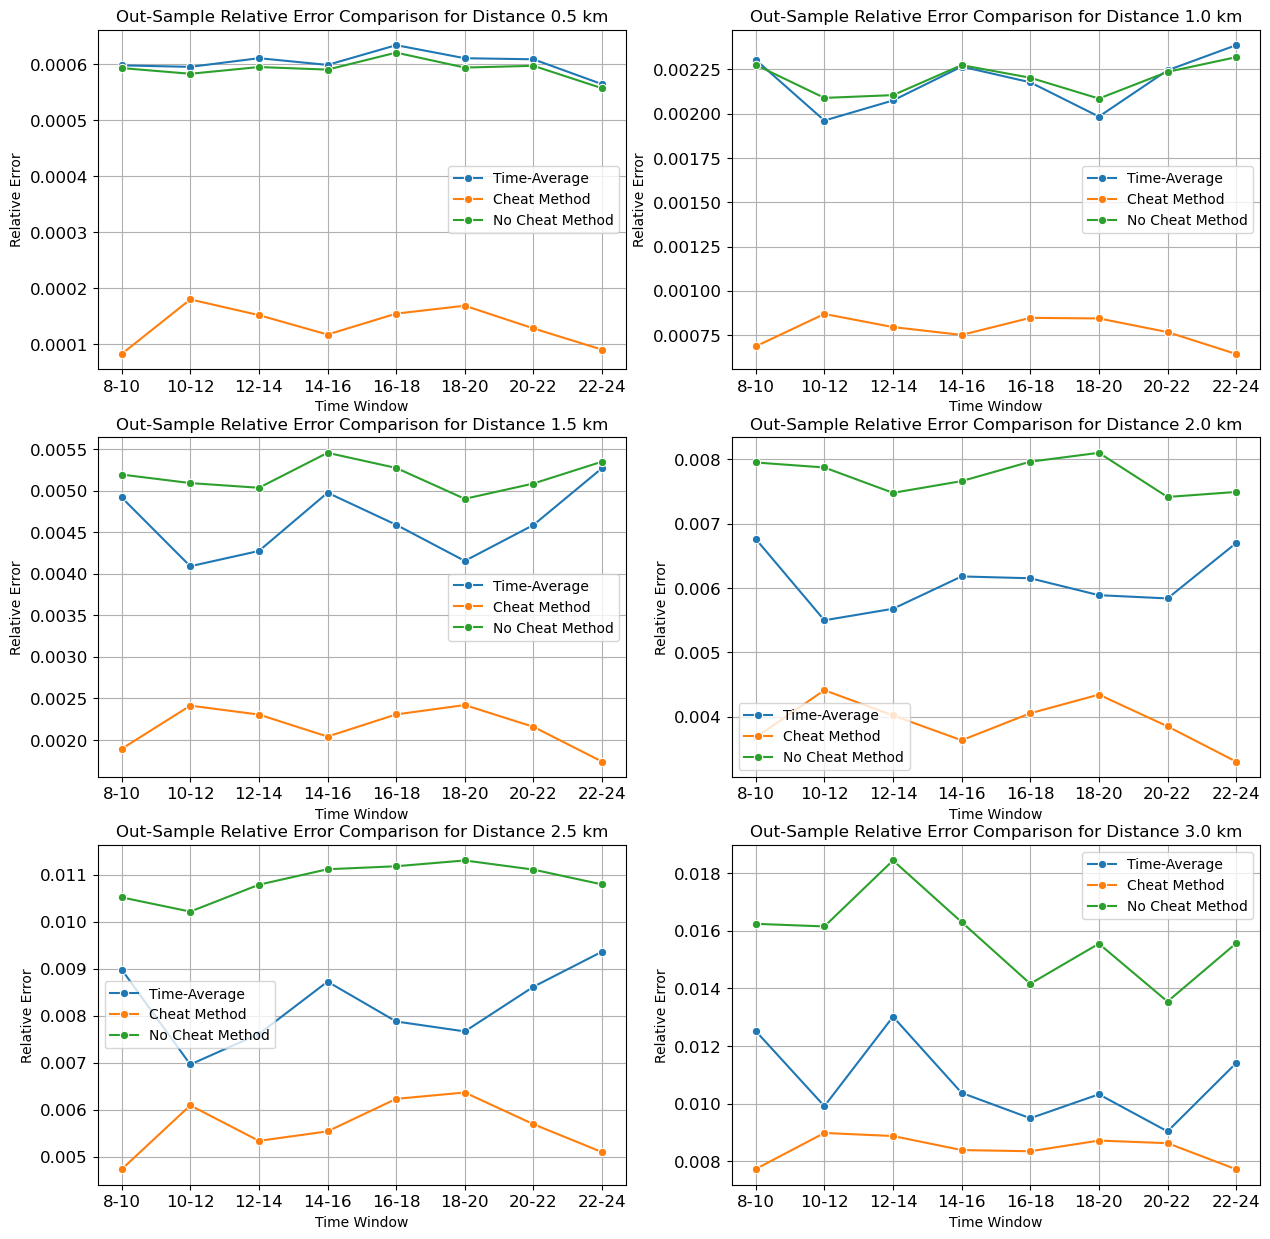

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()
for i, dpg in enumerate(distances):     
    subset = comparison_df[comparison_df['Distance'] == dpg]
    sns.lineplot(x='Time Window', y='Time-Average Out Relative Error', data=subset, marker='o', label='Time-Average', ax=axes[i])
    sns.lineplot(x='Time Window', y='Cheat Method Out Relative Error', data=subset, marker='o', label='Cheat Method', ax=axes[i])    
    sns.lineplot(x='Time Window', y='No Cheat Method Out Relative Error', data=subset, marker='o', label='No Cheat Method', ax=axes[i])
    axes[i].set_title(f'Out-Sample Relative Error Comparison for Distance {dpg} km')
    axes[i].set_ylabel('Relative Error')
    axes[i].set_xlabel('Time Window')
    axes[i].legend()
    axes[i].grid(True)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

In [ ]:
# WMAPE Comparision with Combined Method

# structural model:
u_ij = v_j + \alpha_i * dist_ij

\alpha_i = f(N_cust, )